# Analisis datos House Pricing Kaggle

In [1]:
#Importando librerias comunes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#importando librerias para sesgos
from scipy.stats import skew, probplot
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
#categoria a numero
from sklearn.preprocessing import OrdinalEncoder
#Escalado de los datos
from sklearn.preprocessing import  StandardScaler
#Identificacion de outliers
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
#Analisis mutual information
from sklearn.feature_selection import mutual_info_regression
#config general
pd.set_option('display.max_columns',0)
sns.set_theme(style="darkgrid")
#importando las carpetas del proyecto al path
from sys import path
import os
path.append(os.path.realpath('../'))
#Importando libreria XGBoost
import xgboost as xgb
#Importando Dependencias Optimizacion XGBoost
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## EDA

In [2]:
#Leyendo dataframes
df_train = pd.read_csv("../datos/train.csv")
df_test = pd.read_csv("../datos/test.csv")

In [3]:
#Analisis inicial
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
df_train.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

In [5]:
#Separando variables numericas y objeto
num_vars = df_train.columns[df_train.dtypes != 'object']
obj_vars = df_train.columns[df_train.dtypes == 'object']

print('\nNumerical vars: ')
print(num_vars.values)
print('\nObject vars: ')
print(obj_vars.values)


Numerical vars: 
['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'SalePrice']

Object vars: 
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'Pav

Algunas variables categoricas como 'OverallQual', 'OverallCond' son tomadas como numericas a pesar de ser categoricas

In [6]:
#Corrigiendo el tipo de los datos mal 
df_train = df_train.astype({"MSSubClass": object, "OverallQual": object,"OverallCond": object,"YearBuilt": object,"YearRemodAdd": object,"BsmtFullBath": object,"FullBath": object,"HalfBath": object,"BedroomAbvGr": object,"KitchenAbvGr": object,"TotRmsAbvGrd": object,"Fireplaces": object,"GarageYrBlt": object,"GarageCars": object,"MoSold": object,"YrSold": object})


#### valores nulos

In [7]:
def count_null(df):
    """
    in: df <dataframe>
    out: <dataframe>
    desc:
    Retorna un DF con el numero de valores nulos, el porcentaje de valores nulos y el tipo de la columna, para las columnas con al menos un valor nulo del df original
    """
    count_null = df.isnull().sum()
    porcen_null = count_null*100/df.shape[0]
    df_desc_nulos = pd.concat([count_null,porcen_null,df.dtypes],axis=1,keys= ["Count","Porcentaje","Type"])
    df_desc_nulos = df_desc_nulos[df_desc_nulos['Count']>0]
    df_desc_nulos.sort_values('Porcentaje',ascending=False,inplace=True)
    return np.transpose(df_desc_nulos)

In [8]:
count_null(df_train)

PoolQC MiscFeature      Alley  ... MasVnrArea MasVnrType Electrical
Count            1453        1406       1369  ...          8          8          1
Porcentaje  99.520548    96.30137  93.767123  ...   0.547945   0.547945   0.068493
Type           object      object     object  ...    float64     object     object

[3 rows x 19 columns]

##### Heatmap valores nulos

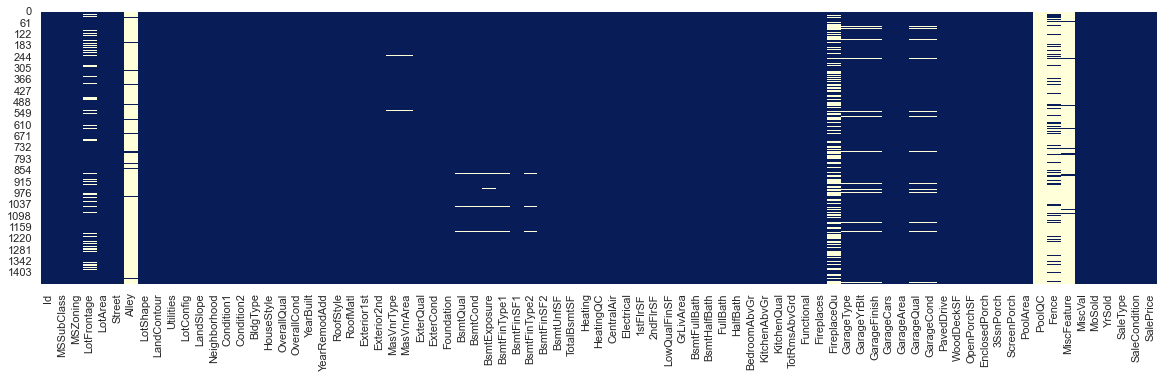

In [9]:
fig,ax = plt.subplots(figsize=(20,5))
sns.heatmap(df_train.isnull(), cbar=False, cmap='YlGnBu_r')
plt.show()

Los datos de las variables Garage_x faltan para las mismas muestras, podria significar que la casa no tiene garaje

Los datos de las variables Bsmt_x faltan para las mismas muestras, podria significar que la casa no tiene sotano

Los datos faltantes estan distribuidos equitativamente

In [10]:
#Elimino variables con mayor porcentaje de nulos
df_train.drop(['PoolQC','MiscFeature','Alley','Fence'],axis=1,inplace=True)
df_test.drop(['PoolQC','MiscFeature','Alley','Fence'],axis=1,inplace=True)

In [11]:
#Para los valores nulos de garage y basement supongo que la casa no tiene ese espacio
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(0)
#df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(0)
for c in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    df_train[c] = df_train[c].fillna('None')
    #df_test[c] = df_test[c].fillna('None')

for c in ['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','BsmtFinType1']:
    df_train[c] = df_train[c].fillna('None')
    #df_test[c] = df_test[c].fillna('None')

In [12]:
#Como solo falta un valor para Electrical lo lleno con la moda de la variable
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])

#### Analisis variables independientes categoricas

In [13]:
def fill_missing_cat_columns(data,categorical):
    """
    in: 
    data <dataframe>: es el dataframe que se llenada con los valores missing
    categoricas <list>: variables categoricas
    out:
    <dataframe> : dataframe entrante modificado
    desc: llena los valores vacios del dataframe con los la categoria MISSING
    """
    for c in categorical:
        data[c]=data[c].astype('category')
        if data[c].isnull().any():
            data[c]=data[c].cat.add_categories(['MISSING'])
            data[c]=data[c].fillna('MISSING')

In [14]:
def barplot_categorias(data,categorical):
    """
    in:
    data <dataframe> : el dataframe a graficar
    categorical <list>: lista con las variables categoricas
    desc:
    Grafica para todas la variables de entrada un grafico de barras
    """
    fill_missing_cat_columns(data,categorical)
    f=pd.melt(data,value_vars=categorical)
    g=sns.FacetGrid(f,col='variable',col_wrap=5,sharex=False,sharey=False,height=5)
    g=g.map(sns.countplot,'value',orient='v')
    g.set_xticklabels(rotation=90,fontsize='small',fontweight='light')
    g.fig.tight_layout()


c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


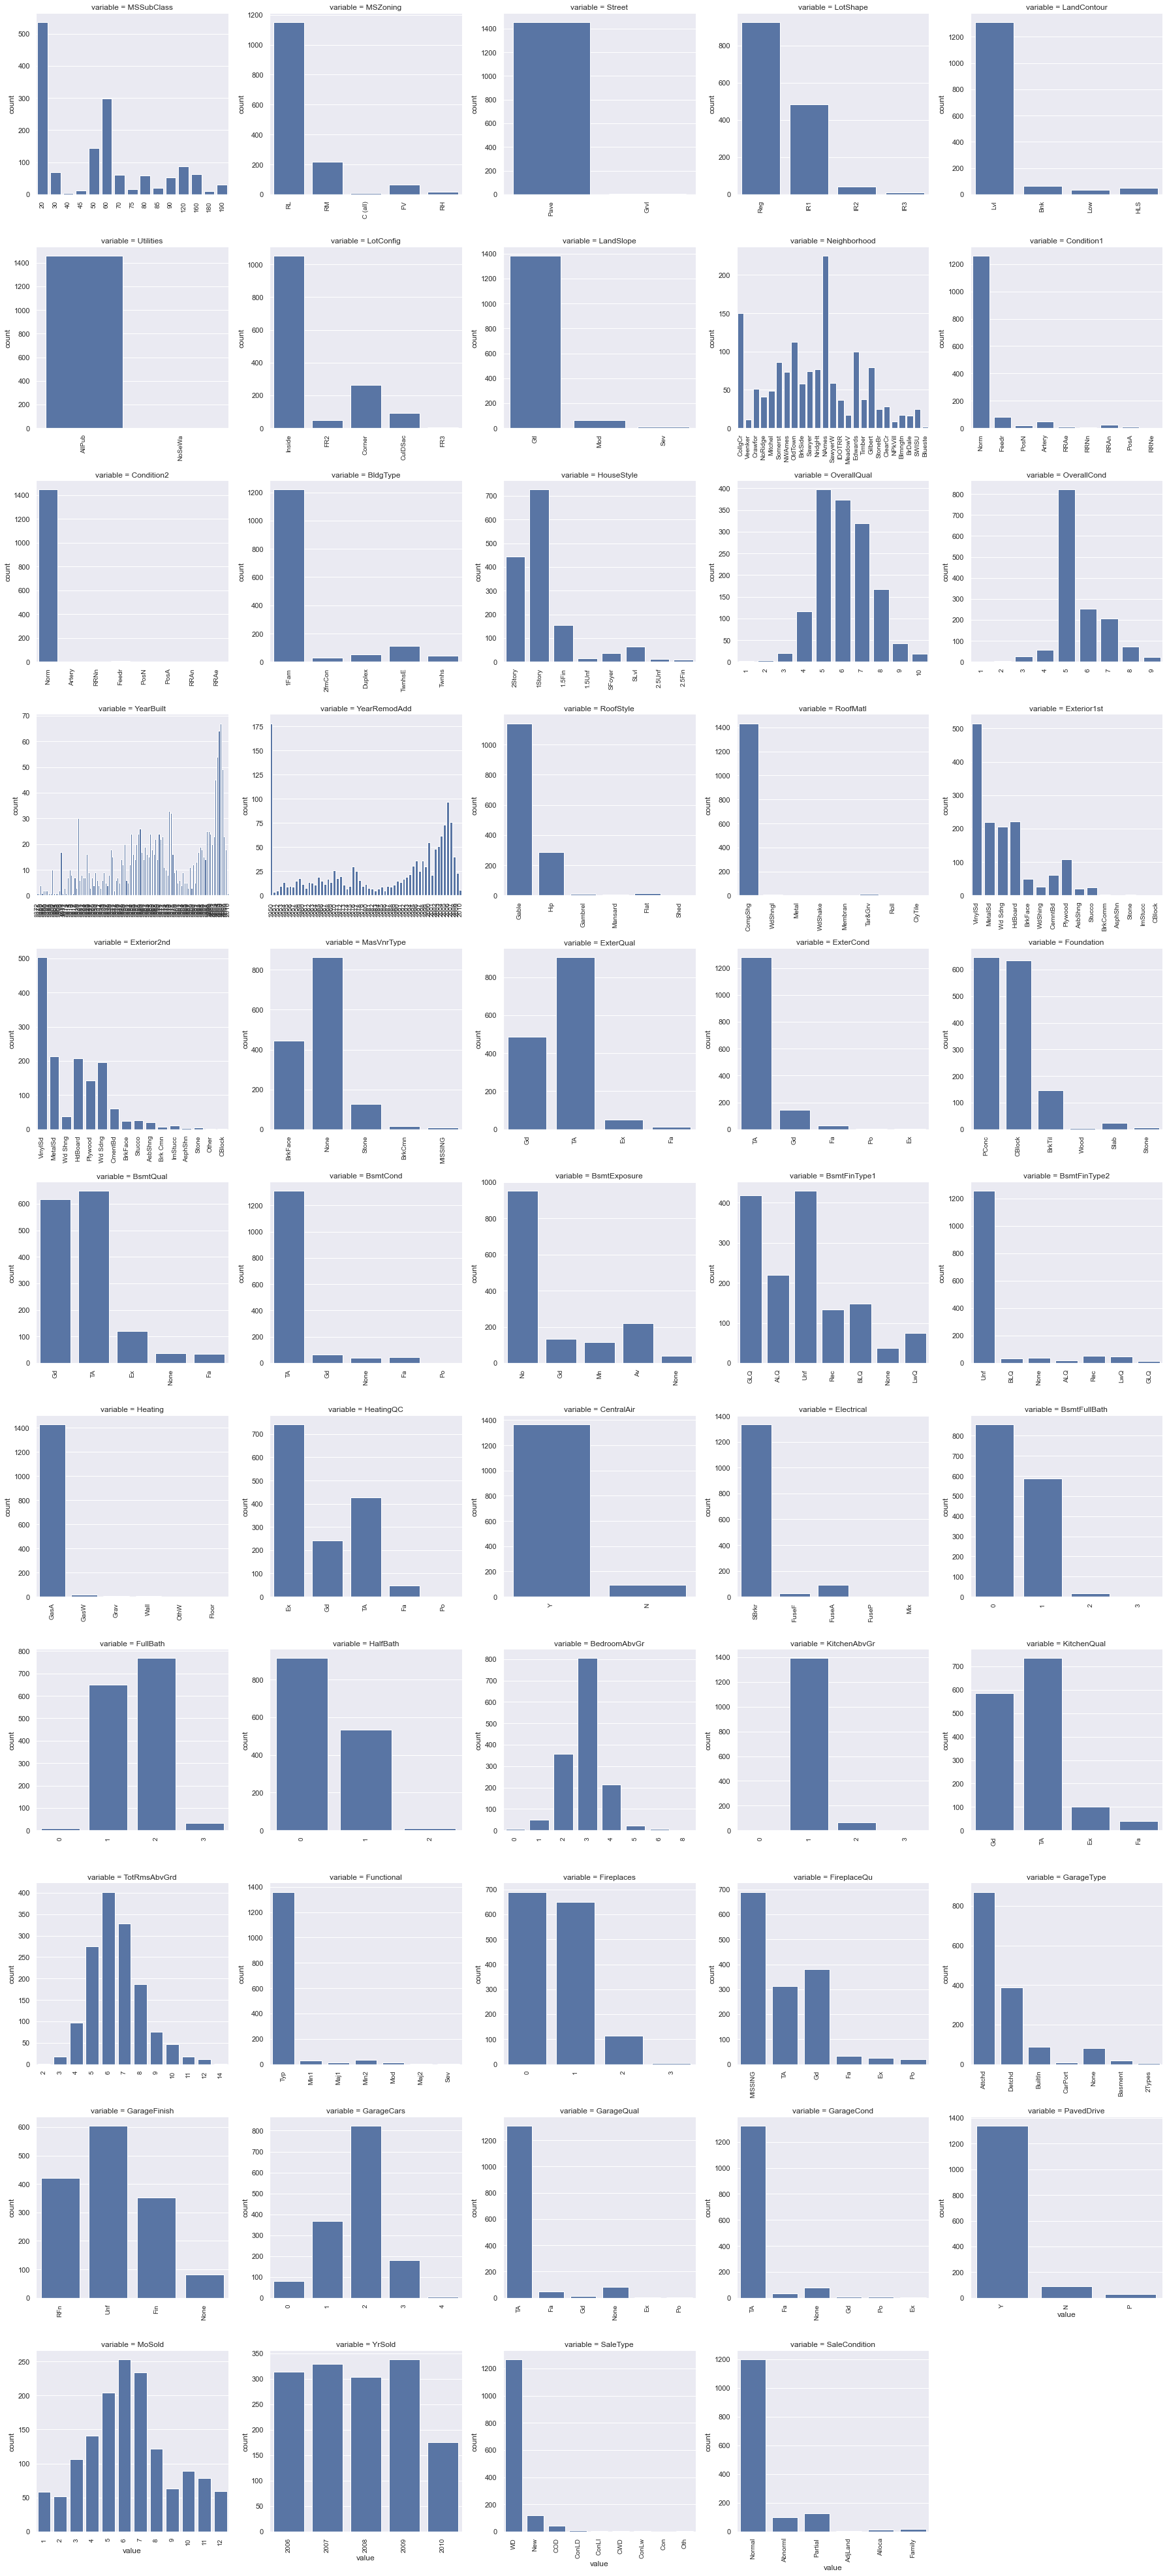

In [15]:
data = df_train.copy()
categorical = data.select_dtypes('object')
barplot_categorias(data,categorical)

Hay varias variables sesgadas a una unica categoria

In [16]:
#Dado que la mayoria de las casas no tienen fireplace, los FireplaceQu faltantes los lleno con none
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('None')

In [17]:
#LLeno los valosre de MasVnrType y MasVnrArea suponiendo que la casa no tiene Mansory
df_train['MasVnrType'] = df_train['MasVnrType'].fillna('None')
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)


#### Analisis variables independientes numericas

In [18]:
def numerical_dist(df,num_features):
    f = pd.melt(df,value_vars=num_features)
    g = sns.FacetGrid(f,col='variable', col_wrap= 5, sharex= False, sharey= False)
    g = g.map(sns.histplot, 'value',kde=True)

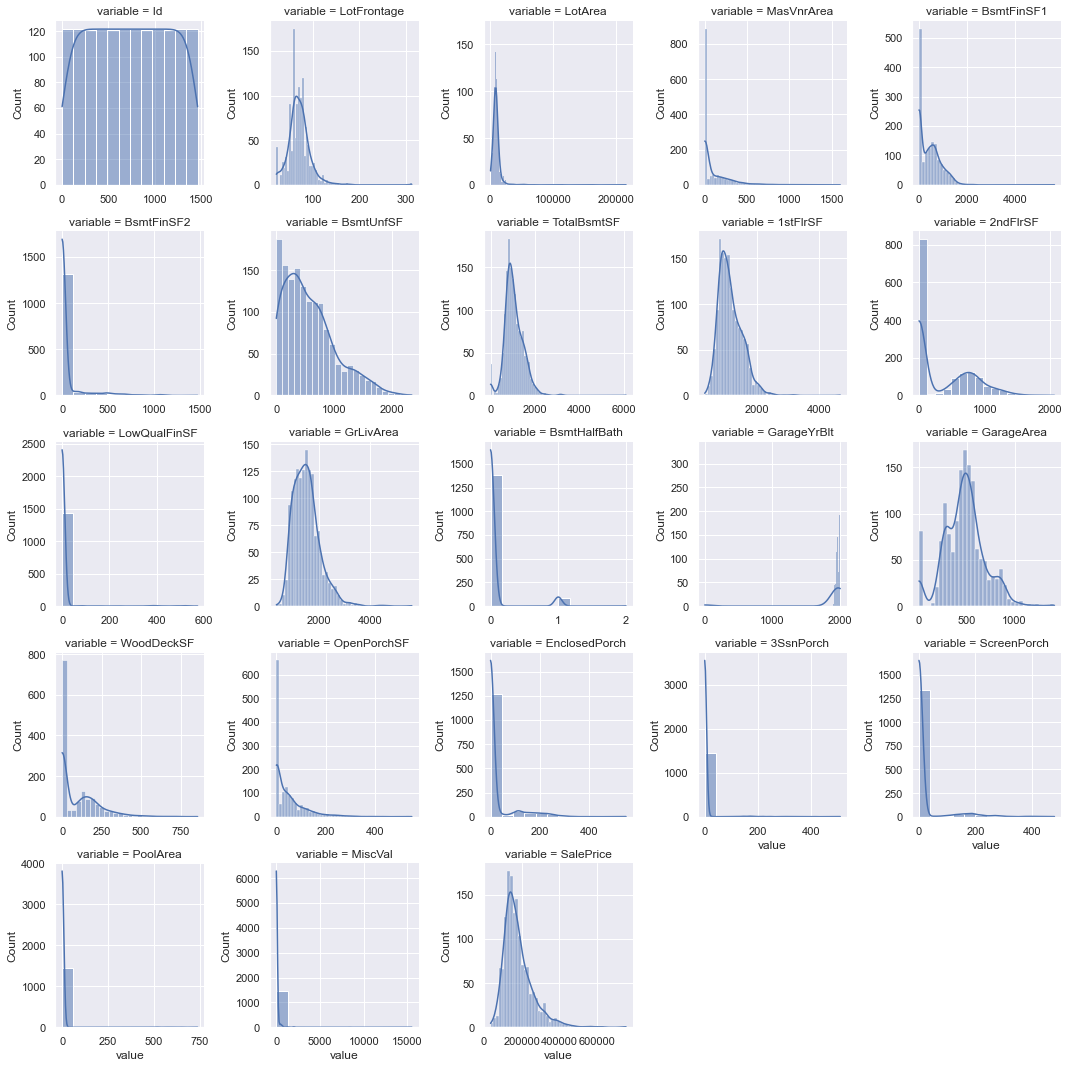

In [19]:
data = df_train.copy()
num_features=data.select_dtypes('number')
numerical_dist(data,num_features)

In [20]:
#Los valores de LotFrontage se llena con la tendencia central segun el barrio
df_train['LotFrontage'] = df_train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Podemos ver varias variables sesgadas hacia el valor de 0, creo no seran utiles en el analisis. Ademas de varias variables sesgadas hacia la izquierda

#### Analisis variable objetivo - salesprice

In [21]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Figure size 1080x360 with 0 Axes>

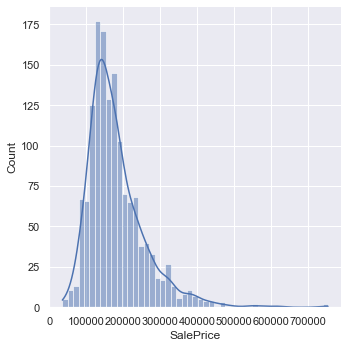

In [22]:
f = plt.figure(facecolor='whitesmoke', figsize=(15, 5))
sns.displot(data=df_train,x='SalePrice',kde=True)

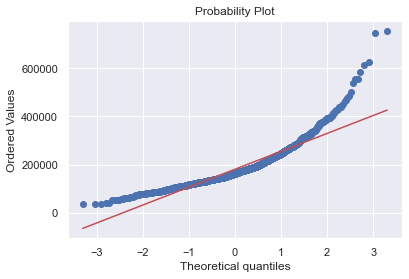

In [23]:
probplot(df_train['SalePrice'],plot=plt)
plt.show()

Por los graficos se puede observar que la distribucion esta sesgada hacia la izquierda

In [24]:
print('La variable objetivo tiene la siguiente skew', df_train['SalePrice'].skew())
print('La variable objetivo tiene la siguiente kurt', df_train['SalePrice'].kurt())

La variable objetivo tiene la siguiente skew 1.8828757597682129
La variable objetivo tiene la siguiente kurt 6.536281860064529


La kurtosis mide la forma de campana de la distribucion, valor positivo indica que hay un pico alargado 

##### ANALISIS INFORMACION MUTUA

La idea es identificar las variables que no aportan a el analisis, ya que como se pudo ver anteriormente muchas variables estan sesgadas o poseen muchos valores nulos


aun faltaria definir como manejar los valores nulos de los datos numericos

In [25]:
X = df_train.copy()
y = X.pop("SalePrice")
categorical = X.select_dtypes("object")
#X.drop(columns=['LotFrontage','MasVnrArea','GarageYrBlt'],inplace=True)
fill_missing_cat_columns(X,categorical)
# Label encoding for categoricals
for colname in categorical:
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y)#, discrete_features=discrete_features
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]
mi_scores[::3]  # show a few features with their MI scores
#mi_scores[:23]
#X.columns[X.isna().any()].tolist()


OverallQual     0.545766
TotalBsmtSF     0.366661
KitchenQual     0.322639
ExterQual       0.311284
GarageYrBlt     0.257510
FireplaceQu     0.209553
GarageType      0.195071
Fireplaces      0.174953
Exterior2nd     0.158411
BsmtFinSF1      0.148991
Exterior1st     0.123953
WoodDeckSF      0.104529
LotShape        0.087737
GarageQual      0.080054
BsmtExposure    0.074641
CentralAir      0.068565
PavedDrive      0.047263
KitchenAbvGr    0.035844
BsmtFullBath    0.026213
RoofStyle       0.022599
MiscVal         0.007072
LotConfig       0.006761
RoofMatl        0.005002
Functional      0.000000
MoSold          0.000000
Id              0.000000
Name: MI Scores, dtype: float64

In [26]:
mi_scores[mi_scores>0.1].shape

(35,)

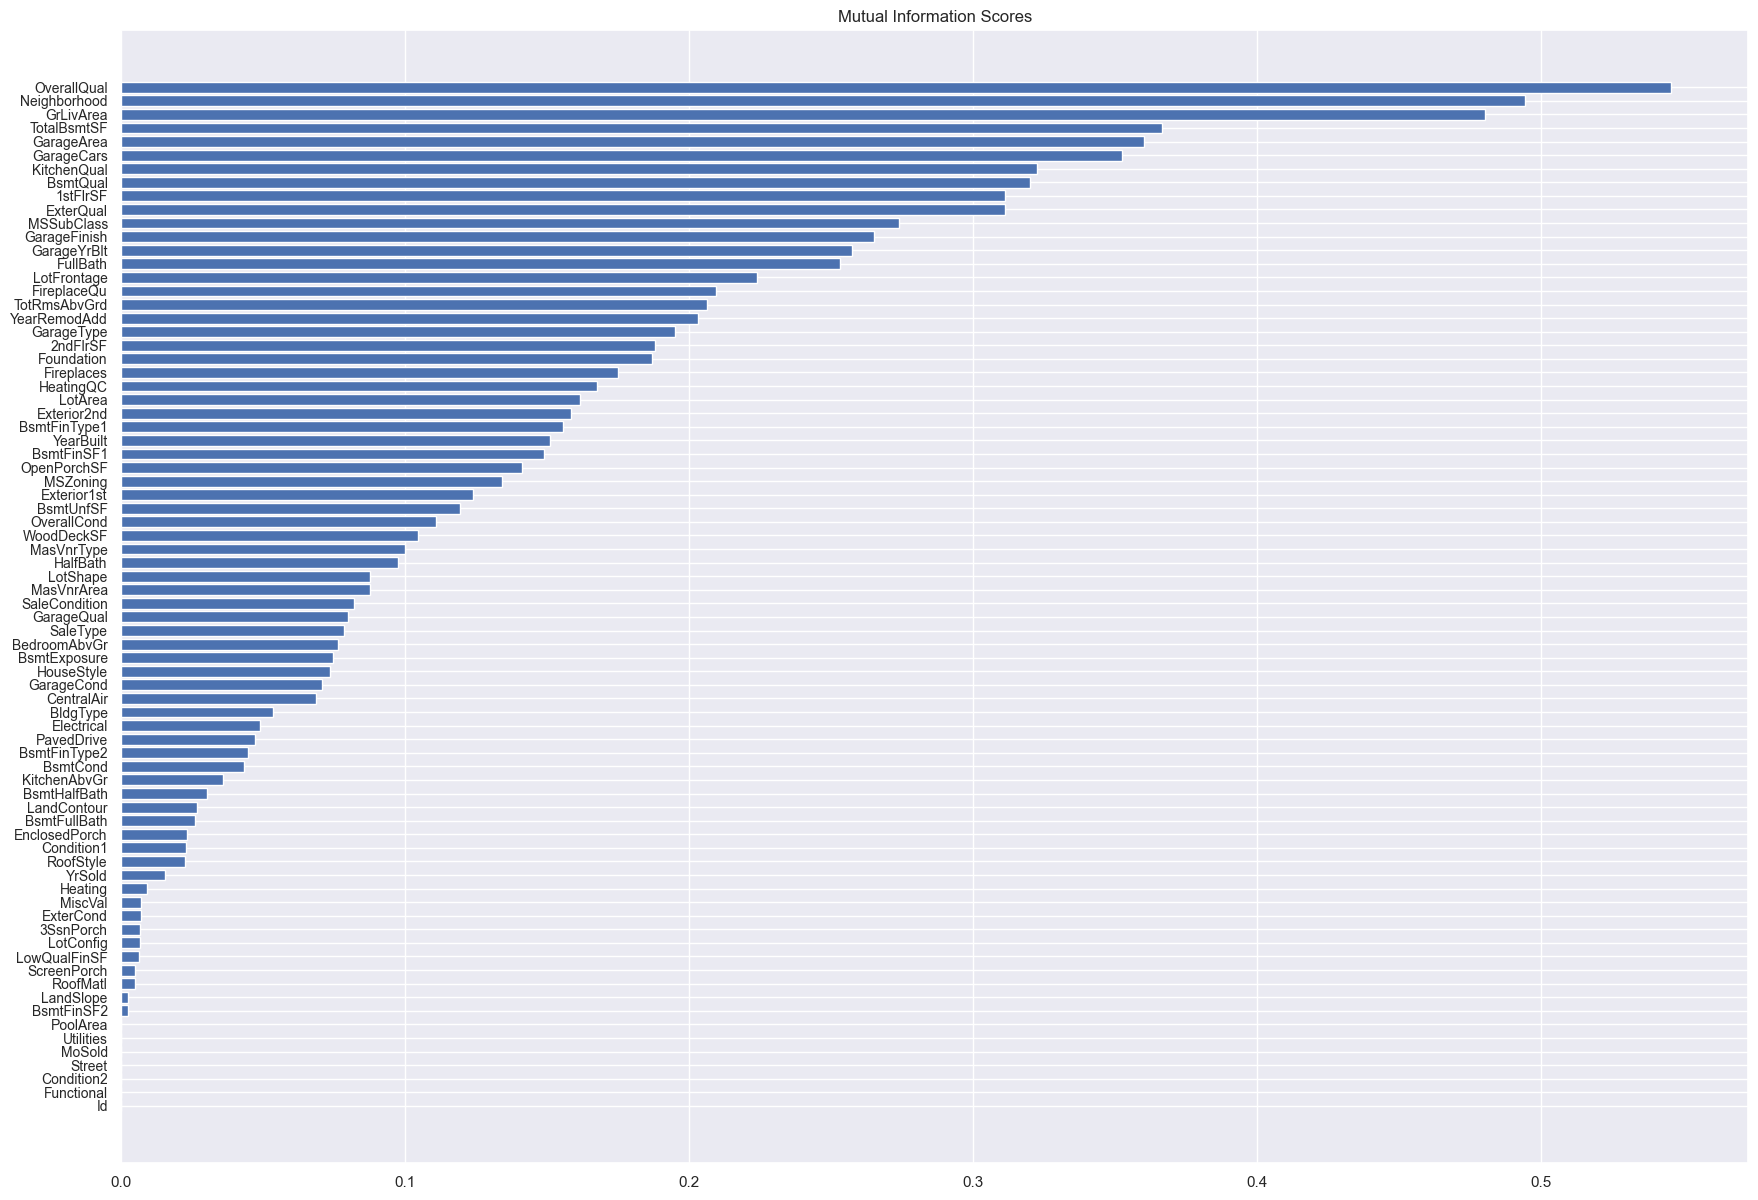

In [27]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks,fontsize=10)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(21, 15))
plot_mi_scores(mi_scores)



Se piensa trabajar con las variables cuyo mutual information sea mayor a 0.1, dado que este metodo se basa en la estimacion de la entropia usando el algoritmo de k-vecinos cercanos,las variables que cumplen este criterio pueden variar ligeramente

In [28]:
lista_varaibles_mi = list(mi_scores[mi_scores>0.1].index)
lista_varaibles_mi.append('SalePrice')
df_train = df_train[lista_varaibles_mi]
df_test = df_test[mi_scores[mi_scores>0.1].index]

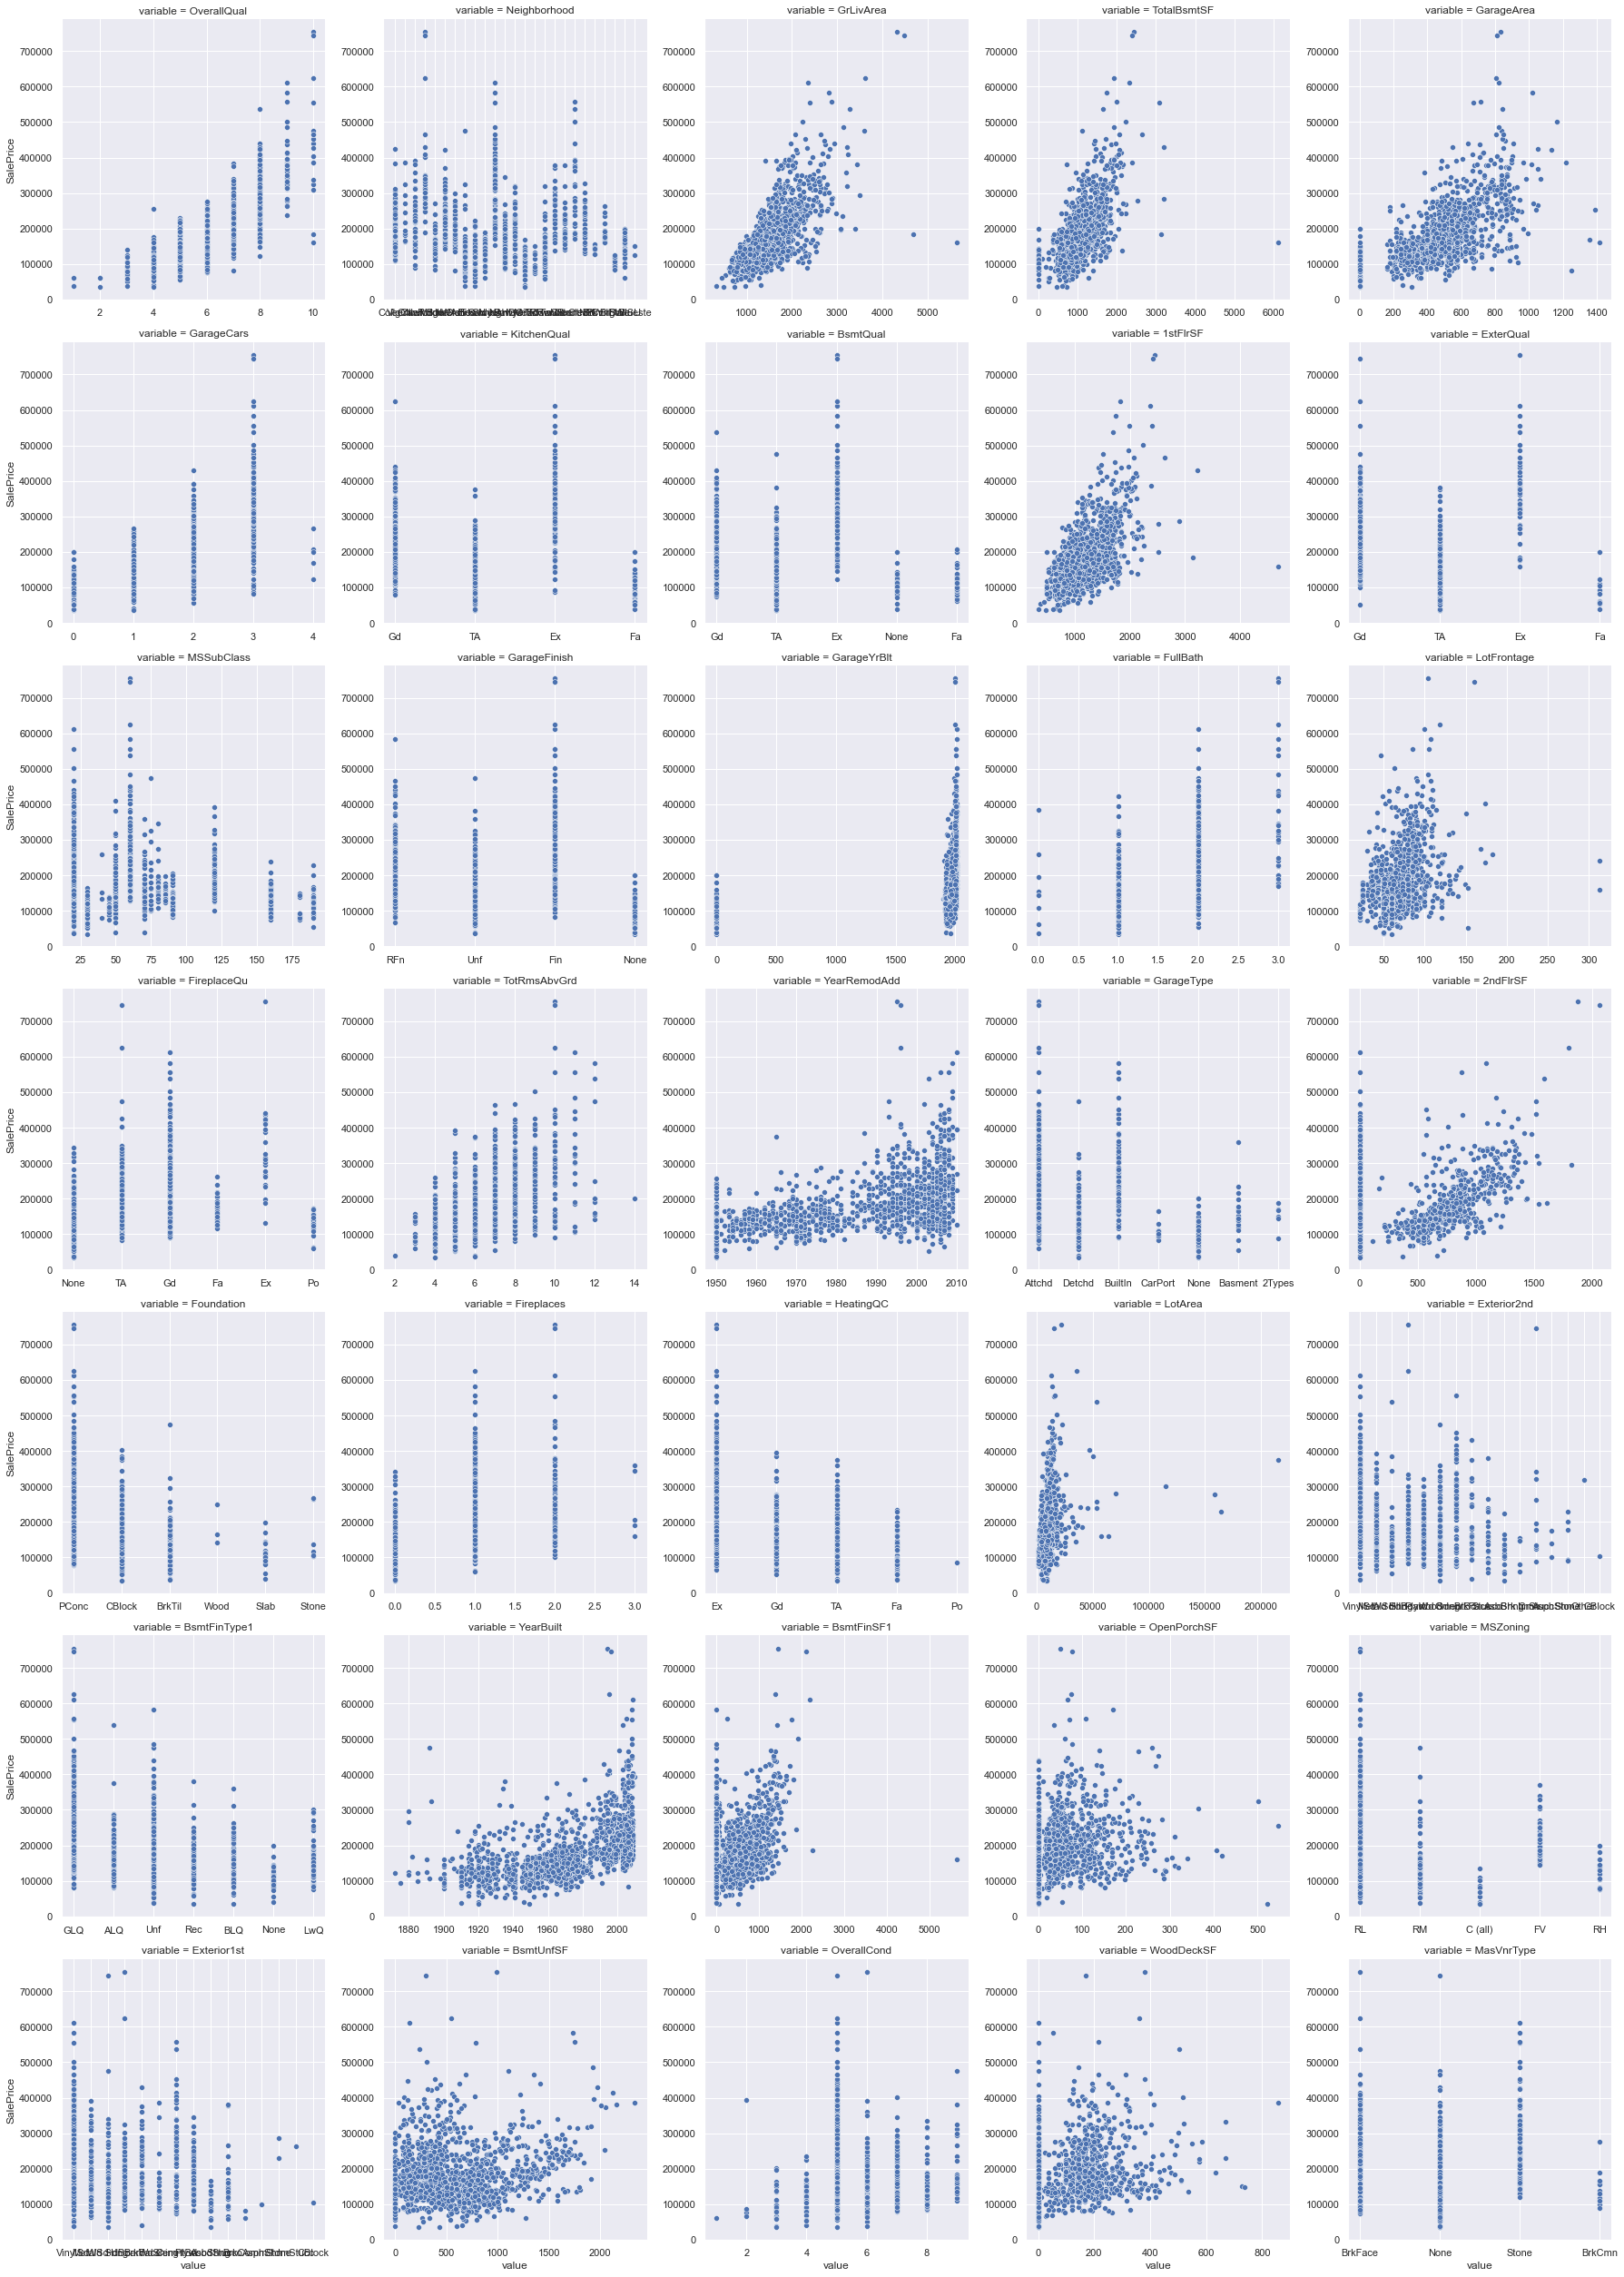

In [29]:
#Graficar mi_score
f = pd.melt(df_train,id_vars='SalePrice',value_vars=mi_scores[mi_scores>0.1].index)
g = sns.FacetGrid(f,col='variable', col_wrap= 5, sharex= False, sharey= False,height=5)
g = g.map(sns.scatterplot,'value','SalePrice')

##### Buscando multicolinealidad

In [30]:
def zoomed_corr_heatmap(df,feature_count,target,fig_size=(12,9)):
    """
    input: 
    df <dataframe> con las variables tanto dependientes como independientes
    feature_count <integer> numero de variables a graficar, incluyendo la variable objetivo, se grafican las que presentan mayor correlacion
    target <string> variable dependiente
    fig_size <tuple> tamaño de la figura
    ouput:
    Heatmap del dataframe ingresado
    desc:
    Esta funcion recibe una dataframe, una variable objetivo y un numero de variables para luego devuelve graficar el heatmap  
    """
    corr_mat = abs(df.corr())
    cols = corr_mat.nlargest(feature_count,target)[target].index
    f,ax = plt.subplots(figsize=fig_size)
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True,annot=True,square=True, fmt='.2f',annot_kws={'size':10},yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

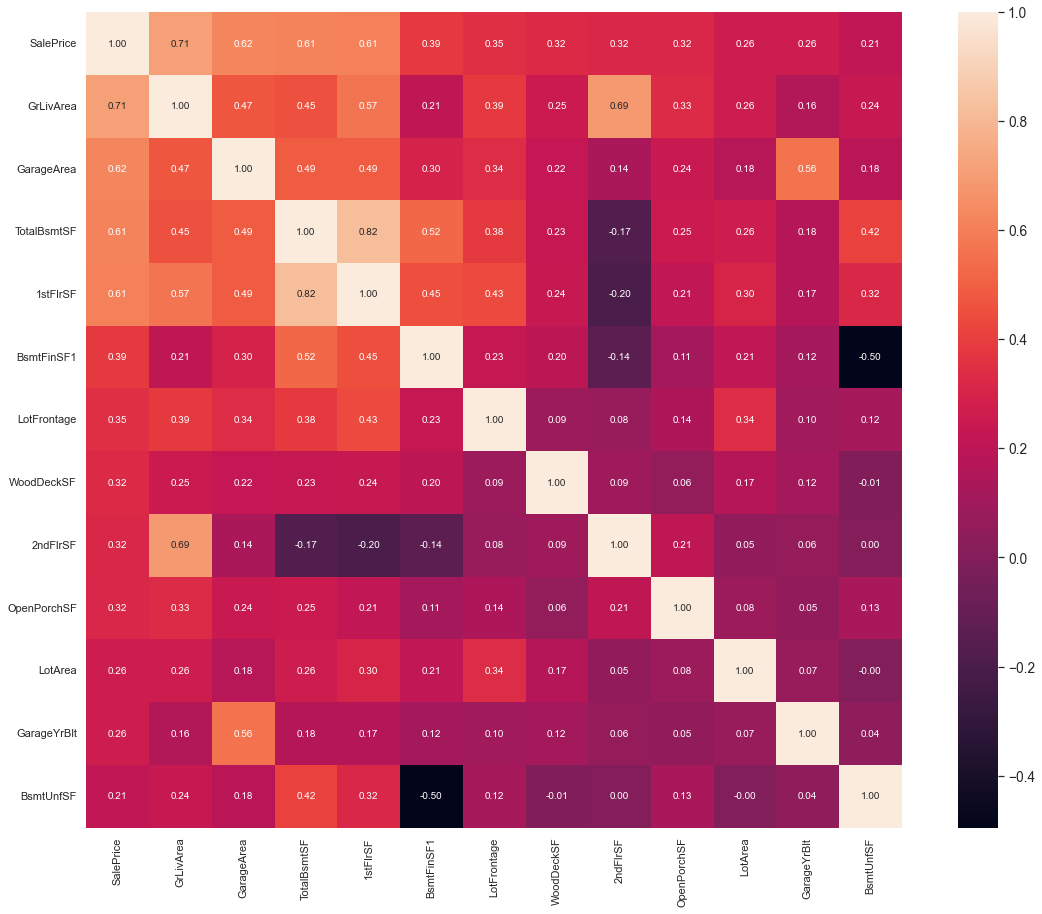

In [31]:
###########LA FUNCION SOLO GRAFICA UN MAXIMO DE 13 VARIABLES#######################
zoomed_corr_heatmap(df_train,len(lista_varaibles_mi),'SalePrice',(20,15))

Algunas variables que presentan multicolinealidad son:

GrLivArea y 2ndFlrSF

GarageYrBlt y GarageArea

TotalBsmtSF y 1stFlrSF 


#### Analisis variables MI

In [32]:
def test_var_cat(feature,target,rank=False):
    """
    input:
    feature <serie> variable independiente a graficar, debe ser categorica
    target <serie> variable dependinete a graficar
    rank <boolean> esta entrada es True si los datos son categoricos representados en numeros
    output:
    grafica con boxplot,residual plot, histplot y probplot de las variables ingresadas
    desc:
    Esta funcion realiza un pequeño resumen de la relacion entre una variable dependiente y una independiente, la variable debe ser categorica
    """
    f,ax= plt.subplots(1,4,figsize=(30,8))
    sns.boxplot(x=feature,y=target,ax=ax[0])
    sns.histplot(x=feature,ax=ax[2],kde=True)
    if rank:
        feature= pd.to_numeric(feature)
        sns.residplot(x=feature,y=target,ax=ax[1],lowess=True)
        probplot(feature,plot=ax[3])
    f.suptitle(f'{feature.name}',weight='bold',size=20)
    f.tight_layout()
    plt.show()

In [33]:
def test_var_con(feature,target):
    """
    input:
    feature <serie> variable independiente a graficar, debe ser numerica
    target <serie> variable dependinete a graficar
    output:
    grafica con regplot,residual plot, histplot y probplot de las variables ingresadas
    desc:
    Esta funcion realiza un pequeño resumen de la relacion entre una variable dependiente y una independiente, la variable debe ser numerica
    """
    f,ax=plt.subplots(1,4,figsize=(30,8))
    sns.regplot(x=feature,y=target,ax=ax[0])
    # sns.regplot(x=x,y=y,ax=ax[1],robust=True)
    sns.residplot(x=feature,y=target,ax=ax[1],lowess=True)
    sns.histplot(x=feature,ax=ax[2],kde=True)
    probplot(feature,plot=ax[3])
    f.suptitle(f'{feature.name}',weight='bold',size=20)
    f.tight_layout()


Se procede a analizar con mas detalle cada una de las variables obtenidas del filtro anterior

##### OverallQual

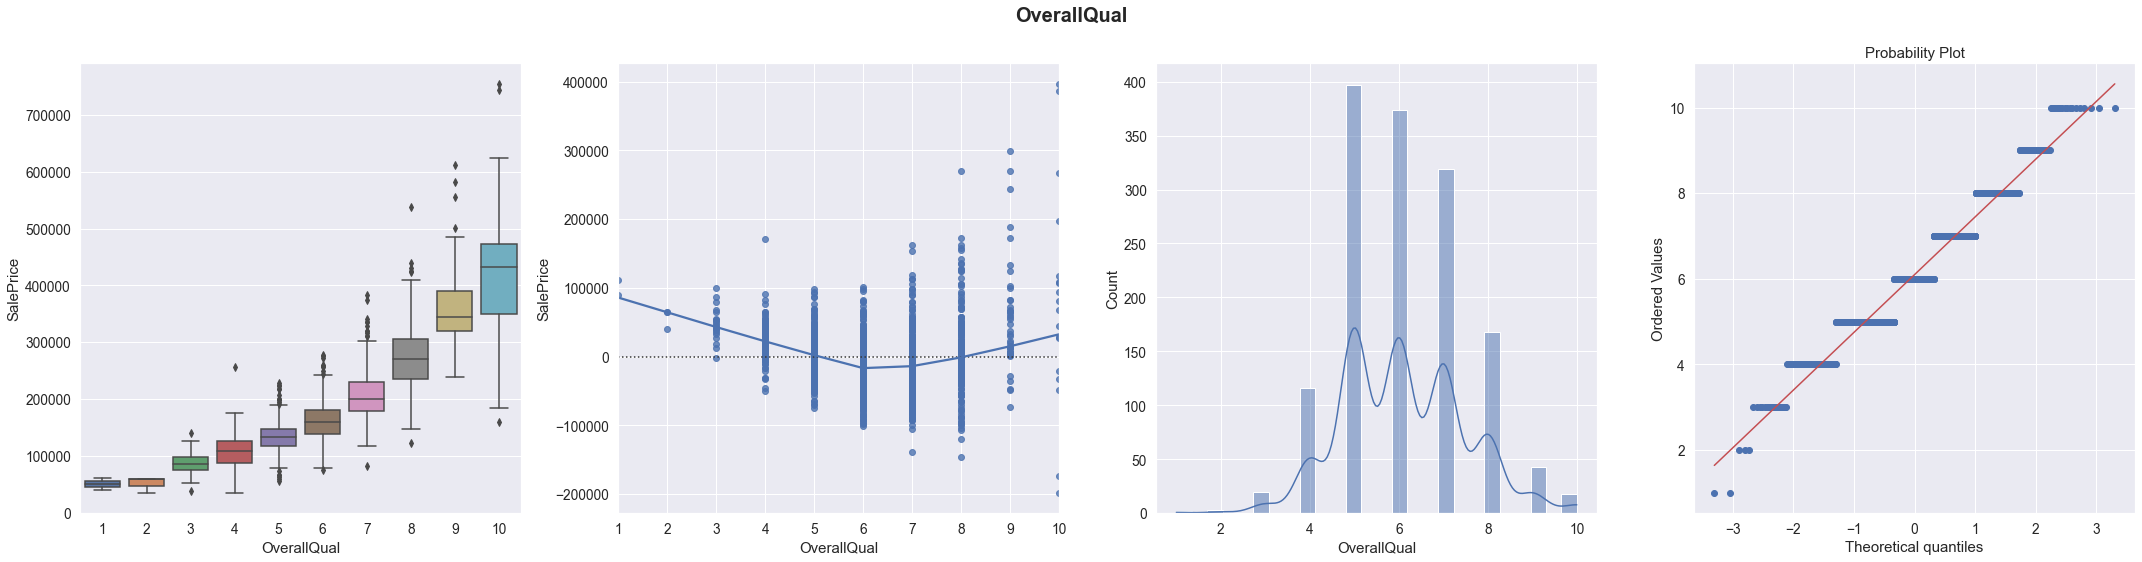

In [34]:
test_var_cat(df_train['OverallQual'],df_train['SalePrice'],rank=True)

Tiene una ralacion lineal y es una variable discriminatoria

##### Neighborhood

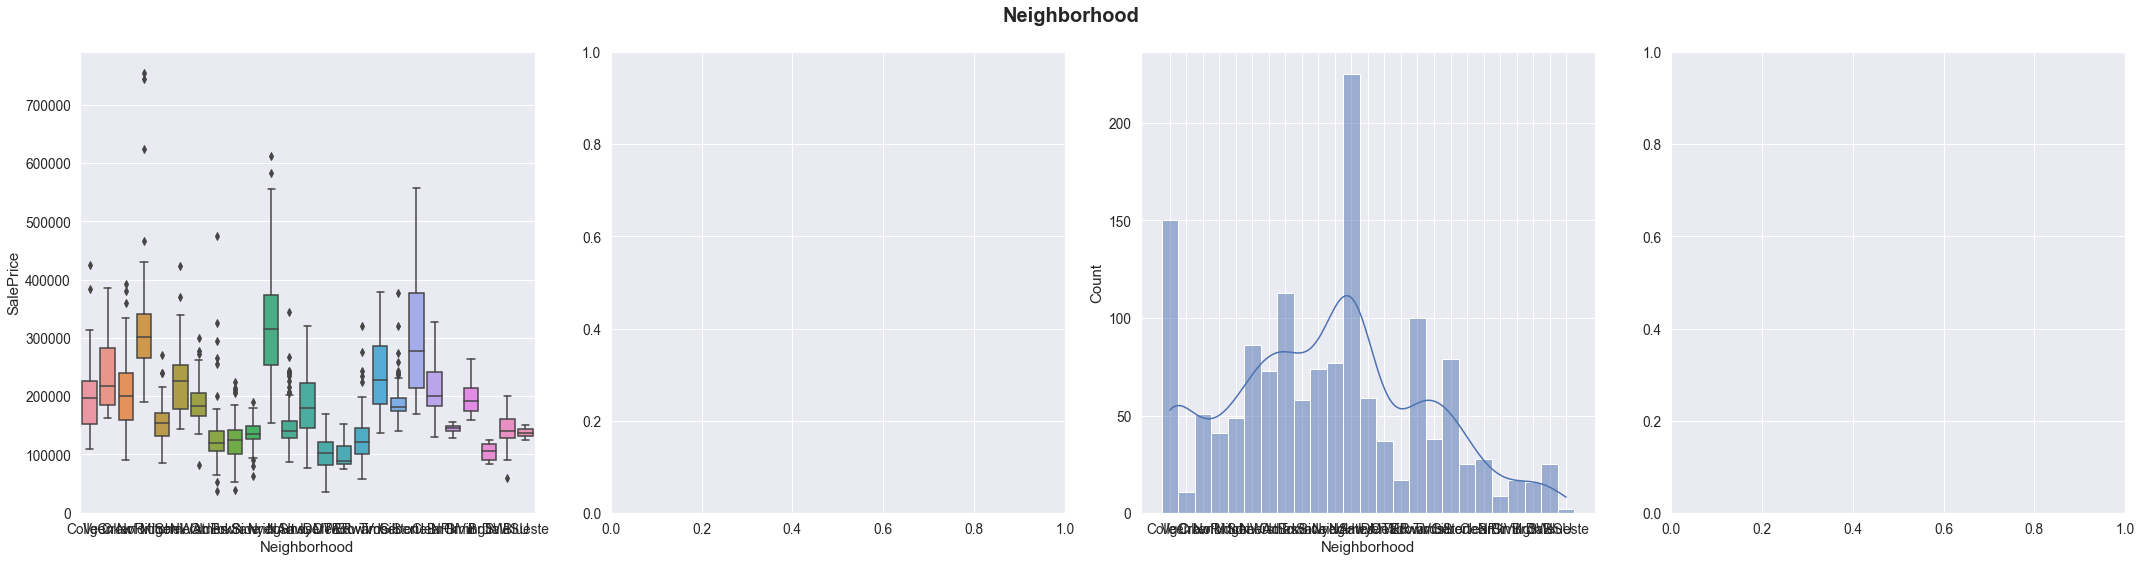

In [35]:
test_var_cat(df_train['Neighborhood'],df_train['SalePrice'])

Aca no se ve mayor relacion pero es posible que sea causado por el orden de graficacion de los datos. segun mi intuicion el barrio es una variable importante a la hora de establecer el precio de una casa

##### GrLivArea

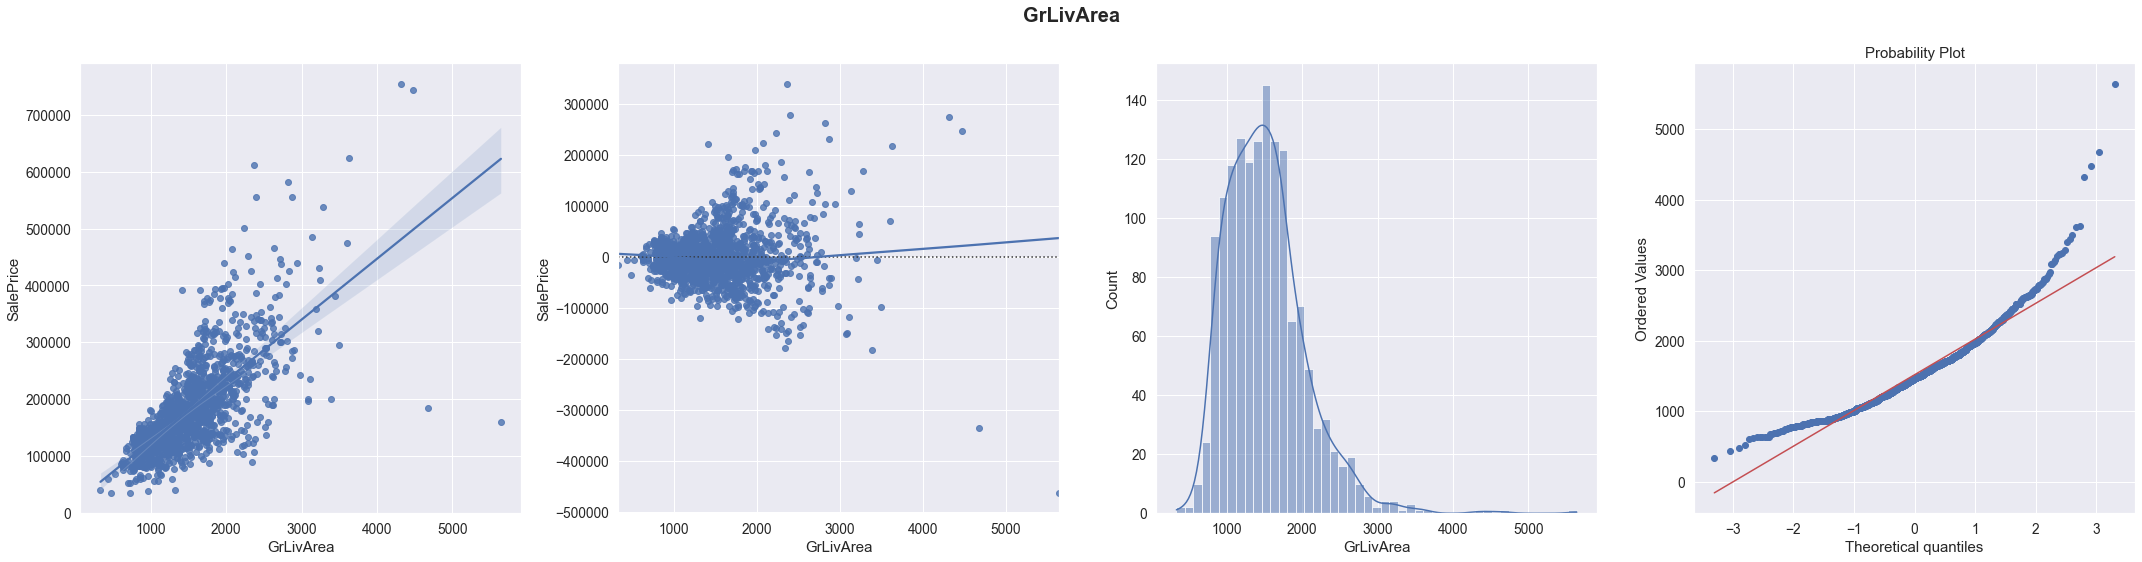

In [36]:
test_var_con(df_train['GrLivArea'],df_train['SalePrice'])

In [37]:
df_train['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

GrLivArea o Area por encima del suelo en ft. GrLivArea tiene una relacion fuerte aunque es una variables sesgada hacia la izquierda y sin homocedasticidad

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

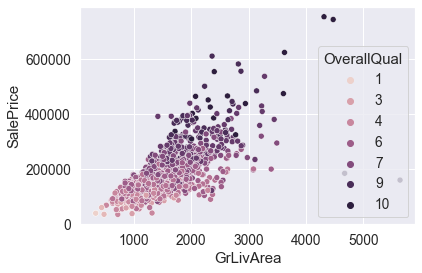

In [38]:
sns.scatterplot(data=df_train,x='GrLivArea',y='SalePrice',hue='OverallQual')

##### TotalBsmtSF

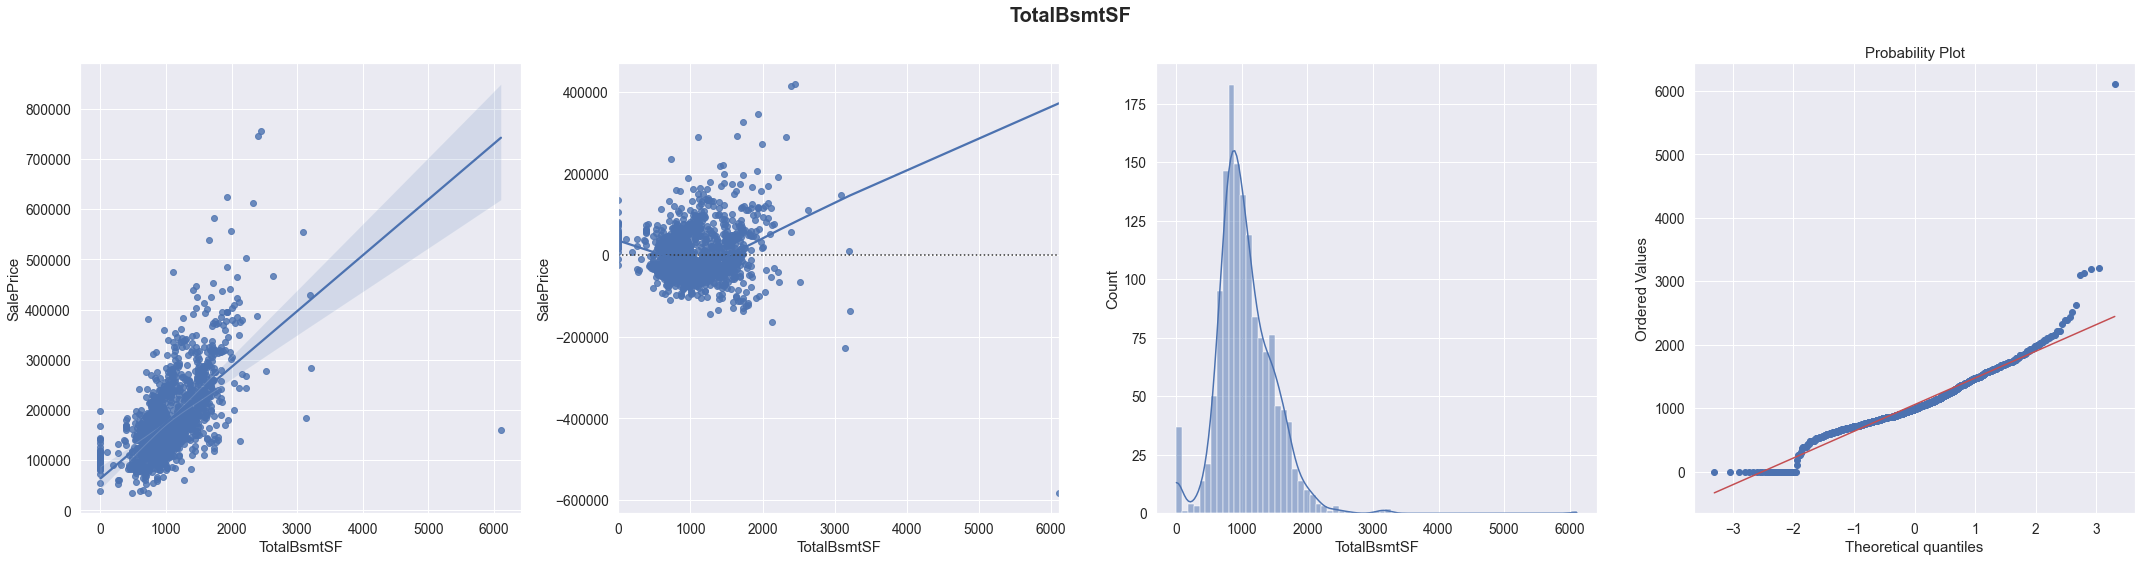

In [39]:
test_var_con(df_train['TotalBsmtSF'],df_train['SalePrice'])

In [40]:
df_train['TotalBsmtSF'].describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

TotalBsmtSF o Area del sotano en ft. Presenta linealidad, un sesgo hacia la izquierda y muy poca homocedasticidad

In [41]:
#sns.scatterplot(data=df_train,x='TotalBsmtSF',y='SalePrice',hue='OverallQual')

##### GarageArea

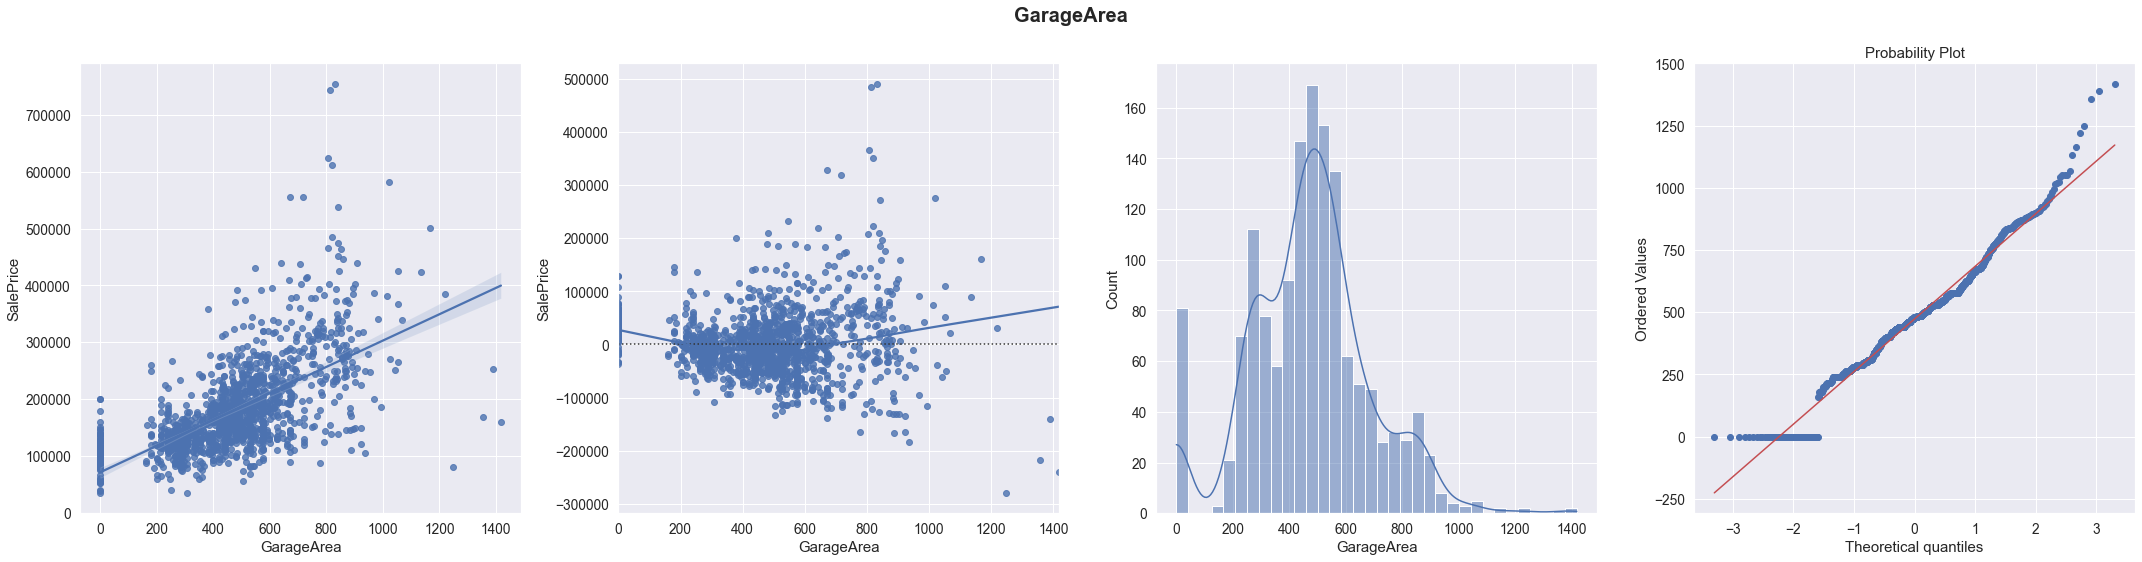

In [42]:
test_var_con(df_train['GarageArea'],df_train['SalePrice'])

In [43]:
df_train['GarageArea'].describe()

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

Presenta multicolinealidad con GarageCars. Tiene problemas de homocedasticidad

##### GarageCars

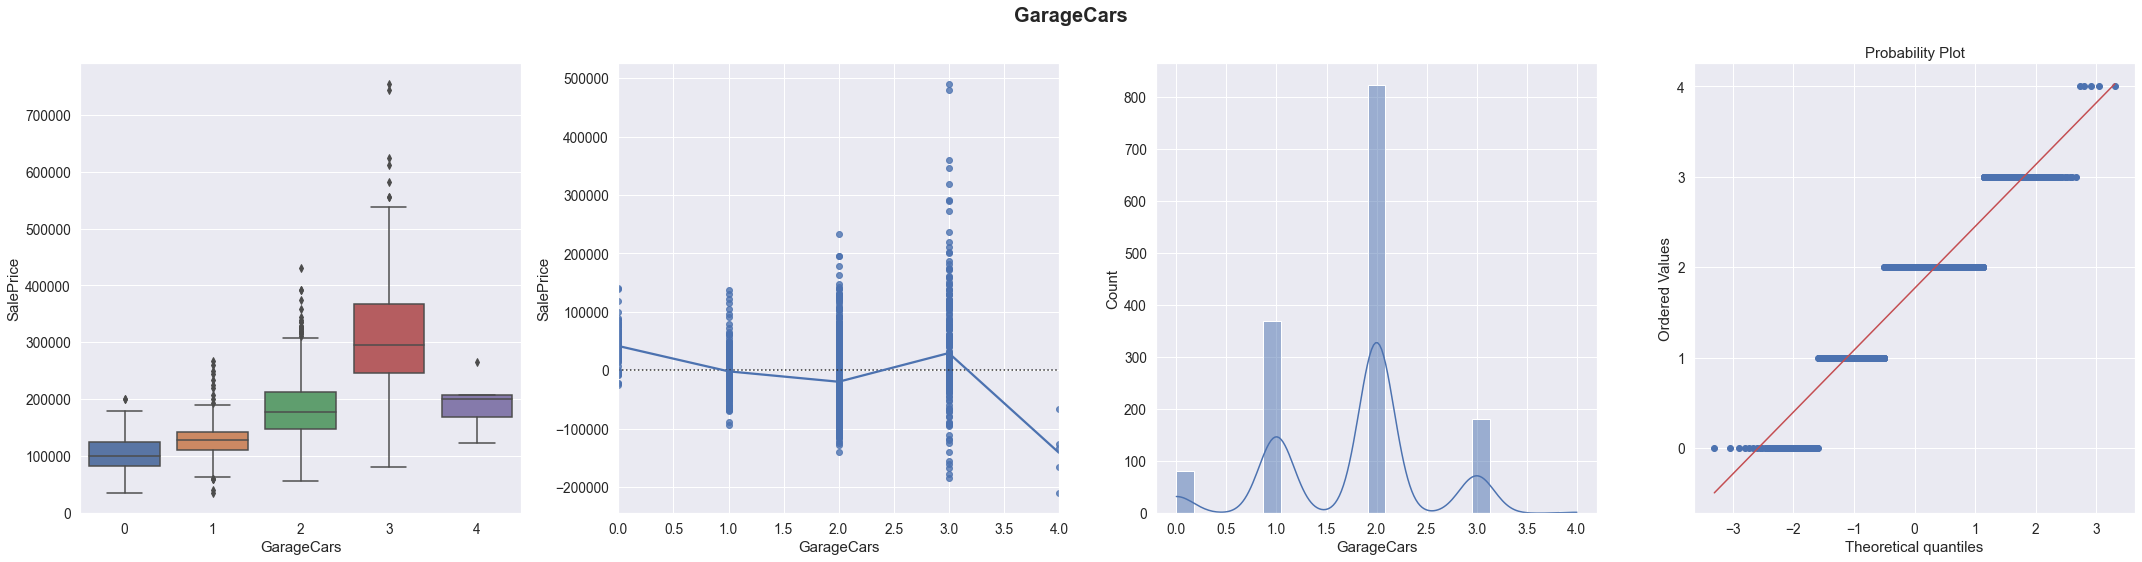

In [44]:
test_var_cat(df_train['GarageCars'],df_train['SalePrice'],rank=True)

Se puede observar en el boxplot que hay una relacion lineal entre el numero de carros y el saleprice, ademas de ser una variable bastante discriminatoria pues los precios de las casas tienen un rango diferente

La moda de los datos es 2 garages

##### ExterQual

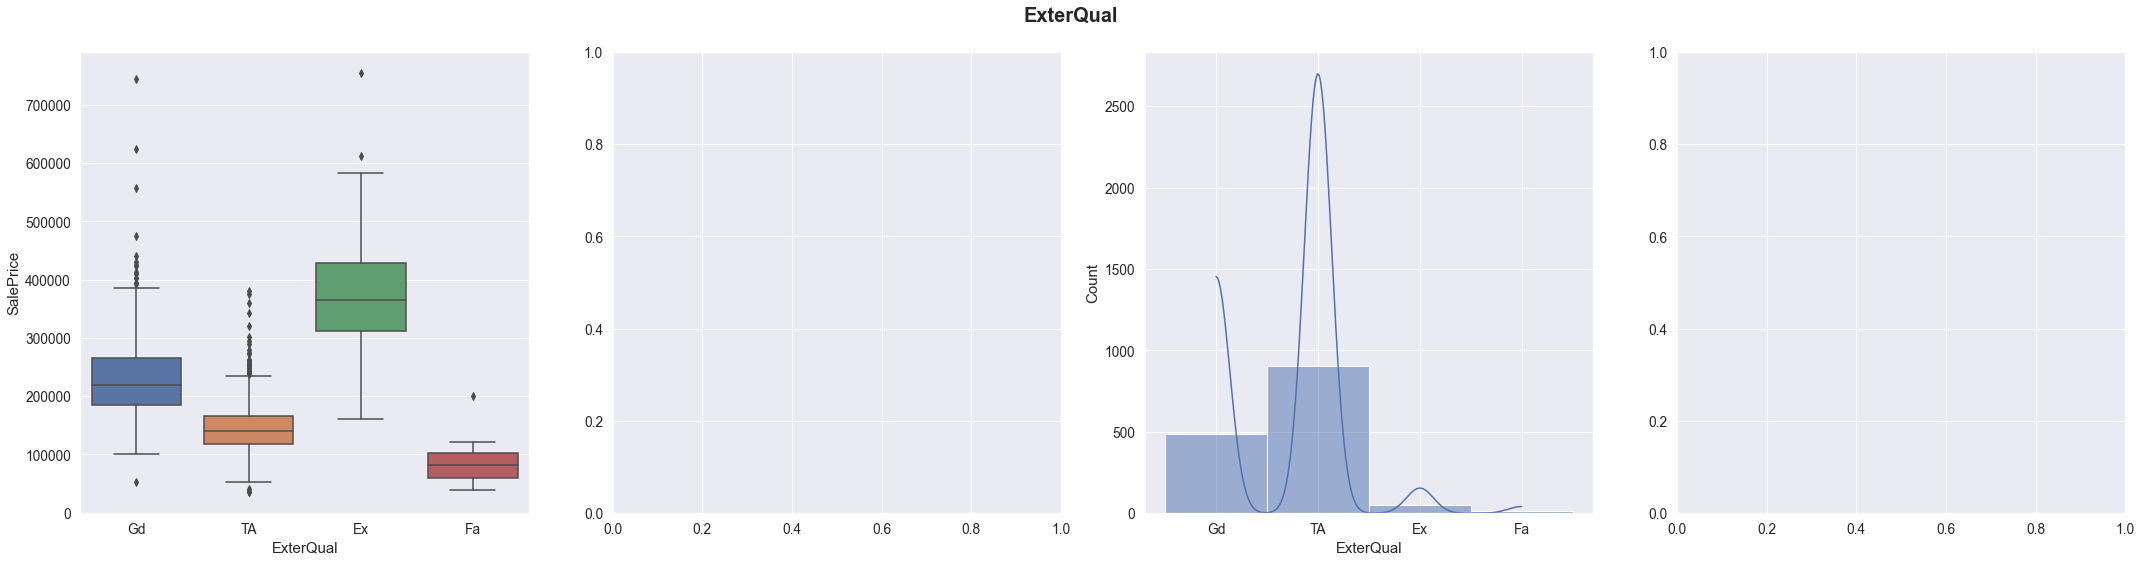

In [45]:
test_var_cat(df_train['ExterQual'],df_train['SalePrice'])

##### KitchenQual

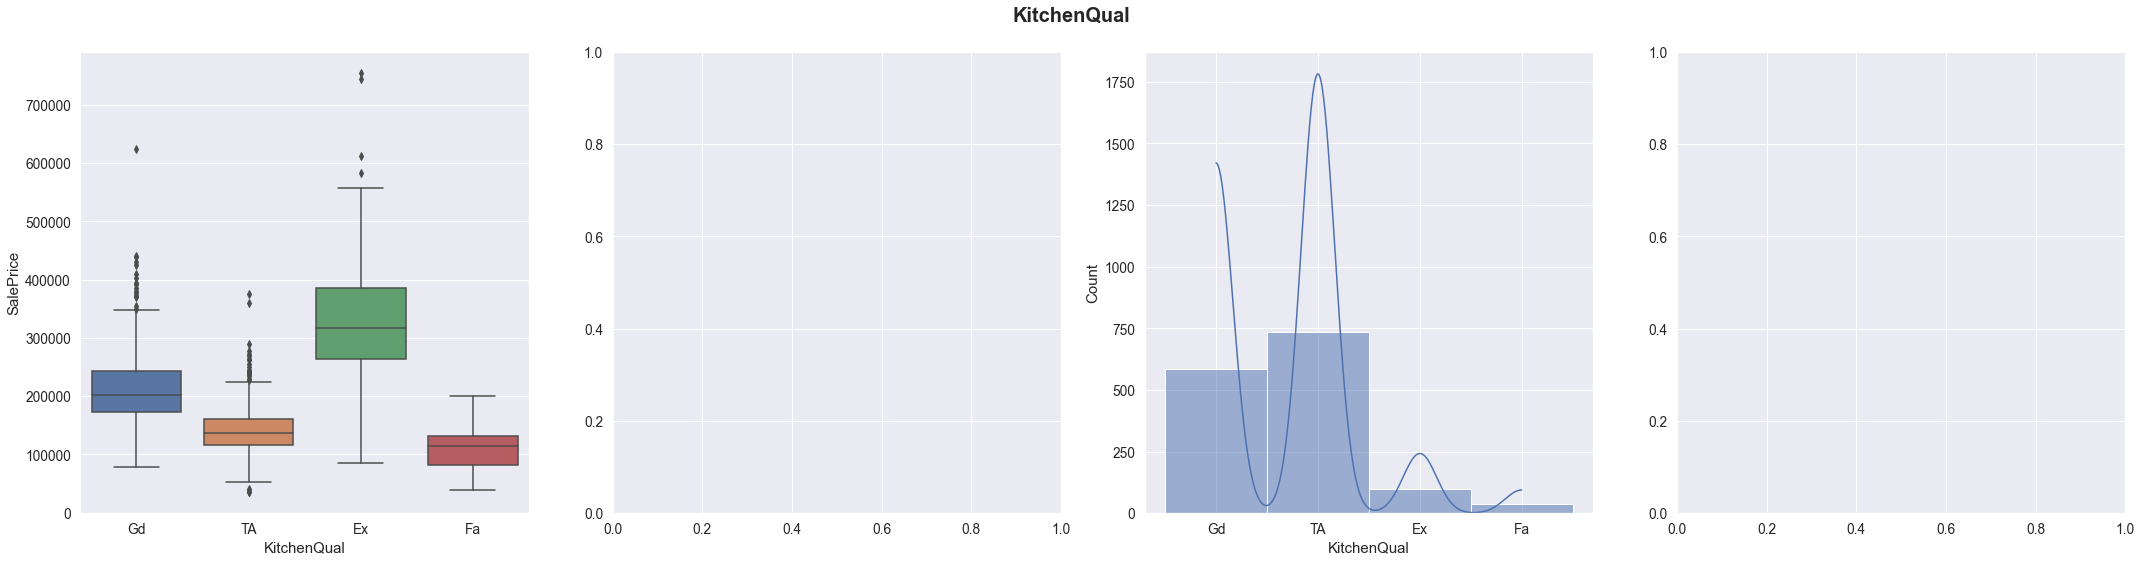

In [46]:
test_var_cat(df_train['KitchenQual'],df_train['SalePrice'])

KitchenQual o calidad cocina es una valor discriminatorio, los mas comunes son bueno y tipico

##### BsmtQual

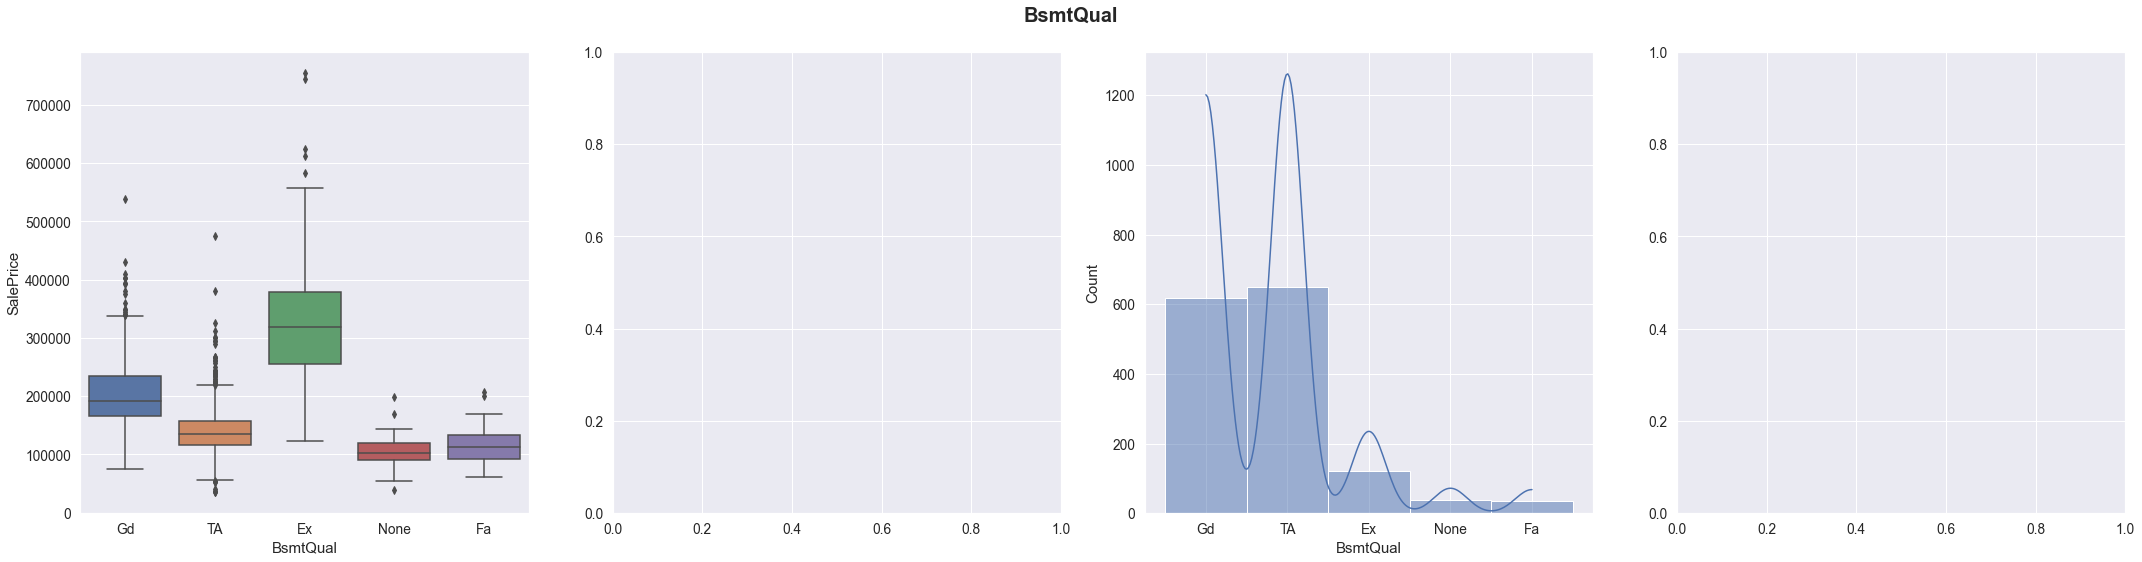

In [47]:
test_var_cat(df_train['BsmtQual'],df_train['SalePrice'])

BsmtQual o la altura del sotano discrimina bien los precios, siendo las alturas mas comunes bueno (90-99 inches) y tipico (80-89 inches)

##### 1stFlrSF

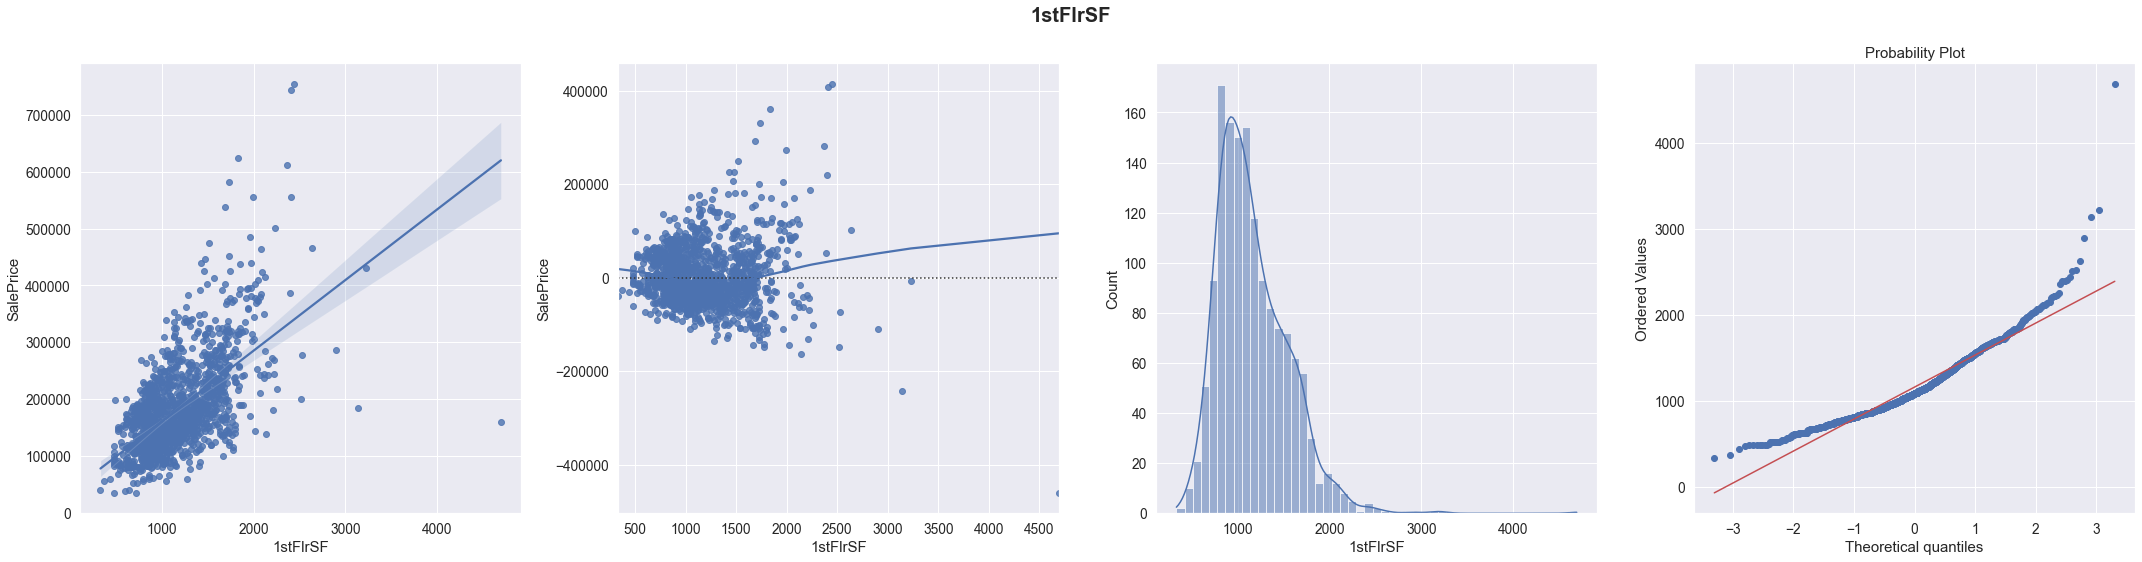

In [48]:
test_var_con(df_train['1stFlrSF'],df_train['SalePrice'])

1stFlrSF o Area del primer piso en ft. Presenta linealidad y un sesgo hacia la izquierda

Presenta multicolinealidad con TotalBsmtSF

##### MSSubClass

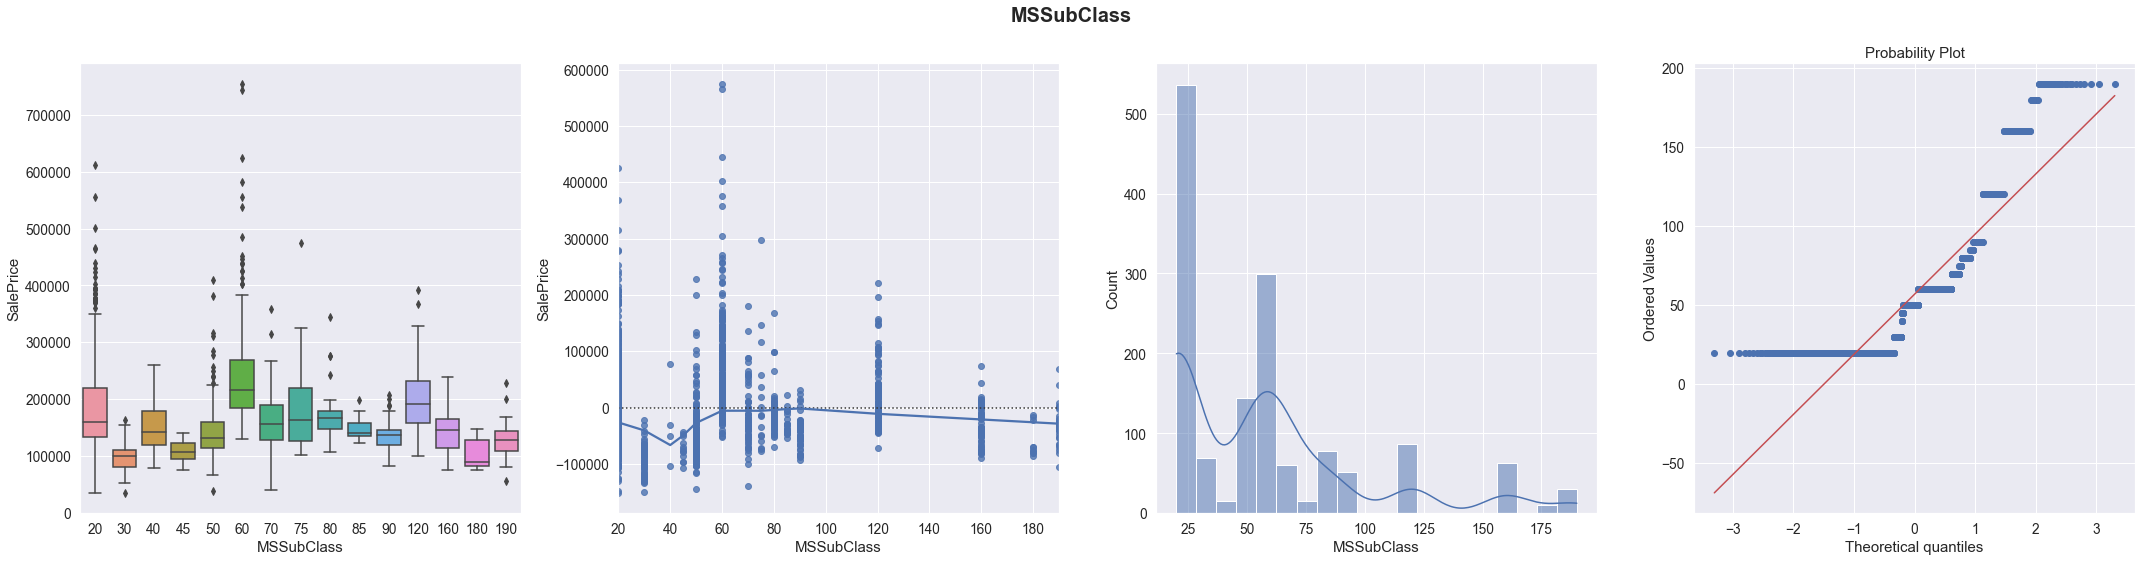

In [49]:
test_var_cat(df_train['MSSubClass'],df_train['SalePrice'],rank=True)

MSSubClass o tipo de vivienda. 

#### FullBath

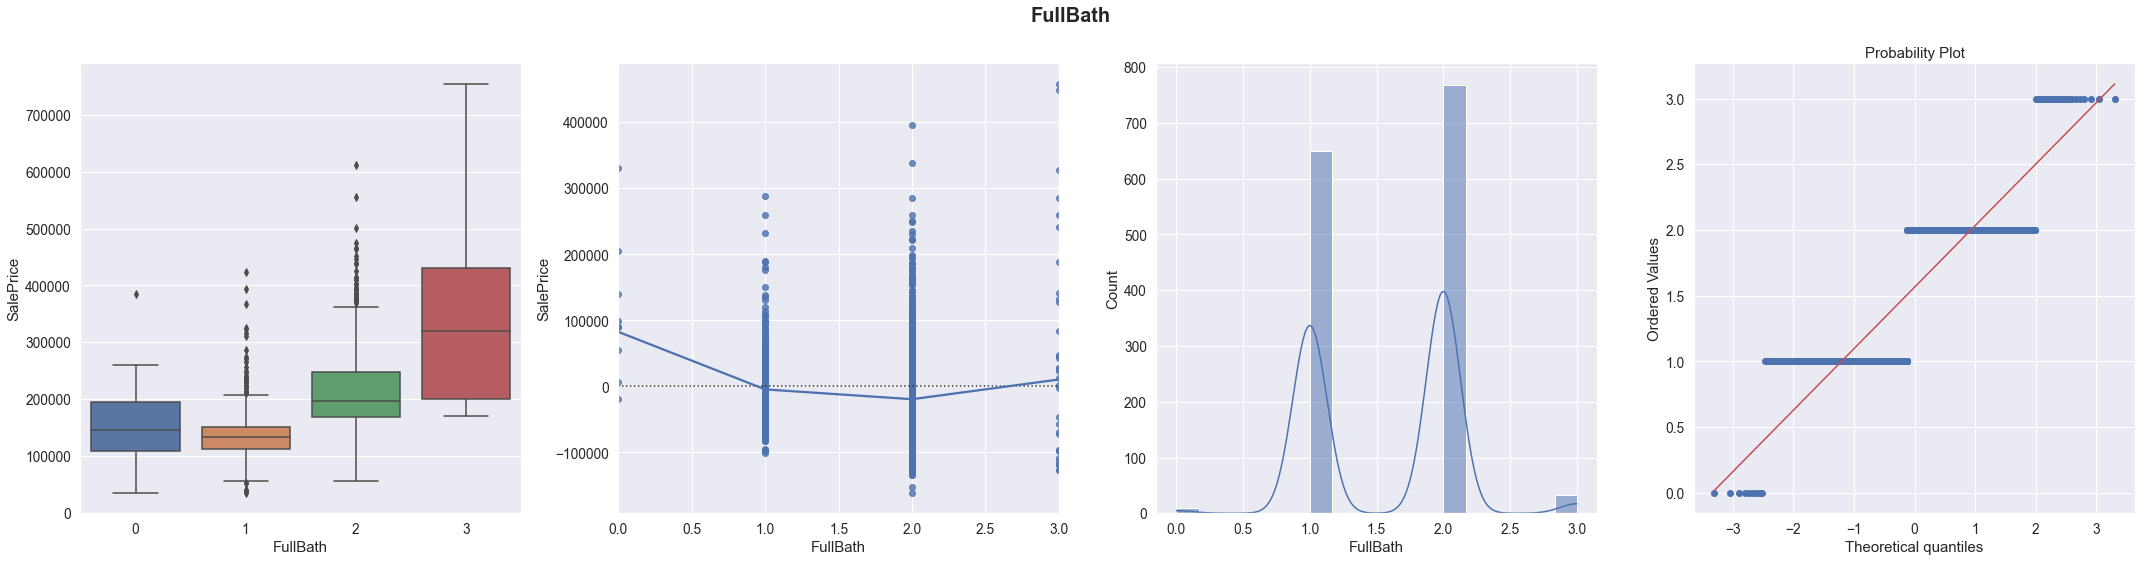

In [50]:
test_var_cat(df_train['FullBath'],df_train['SalePrice'],rank=True)

FullBath o numero de baños por encima del nivel de suelo, es una variable discriminatoria sobre todo para valores mayores a 0, los valores mas comunes son 2 y 1 que presentan un rango diferente, lo cual considero positivo

##### GarageYrBlt

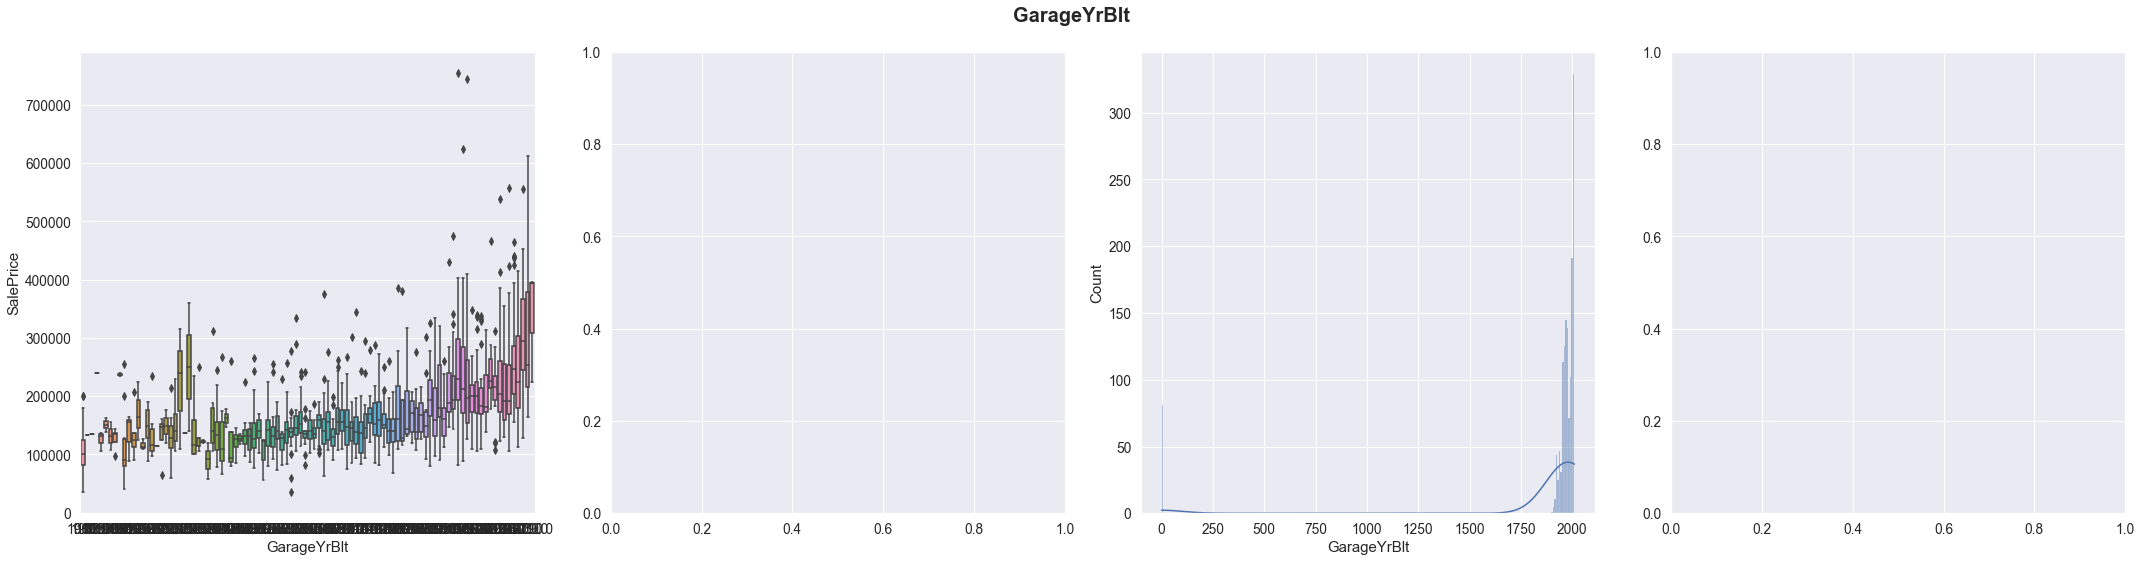

In [51]:
test_var_cat(df_train['GarageYrBlt'],df_train['SalePrice'],)

##### GarageFinish

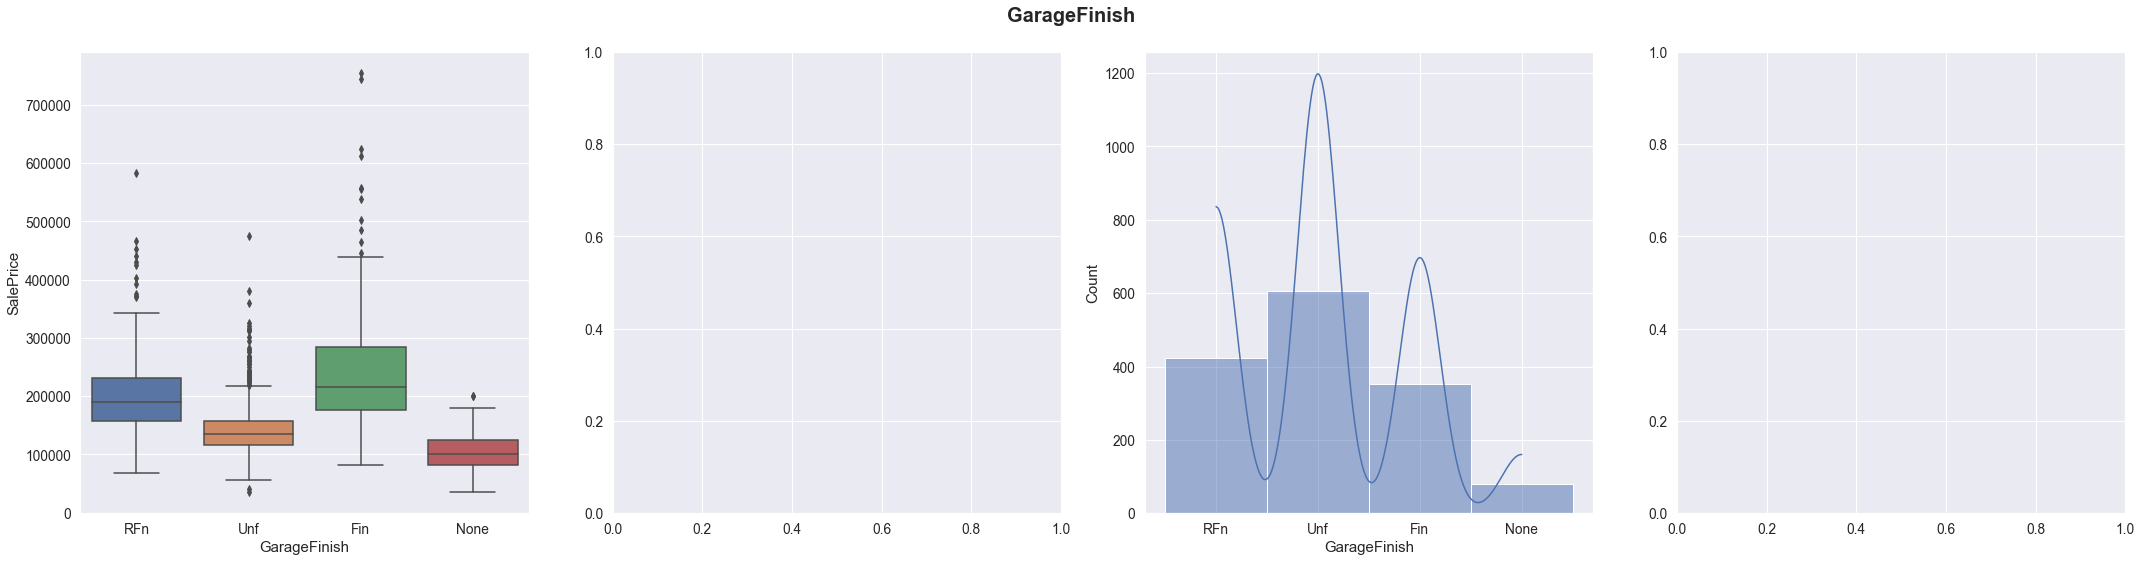

In [52]:
test_var_cat(df_train['GarageFinish'],df_train['SalePrice'])

GarageFinish o la terminacion del garage, presenta una linealidad y como podemos ver no hay casa sin garage, aunque la mayoria no estan terminados. tambien la diferencia no es mucha entre un garage terminado y uno a medias


##### LotFrontage

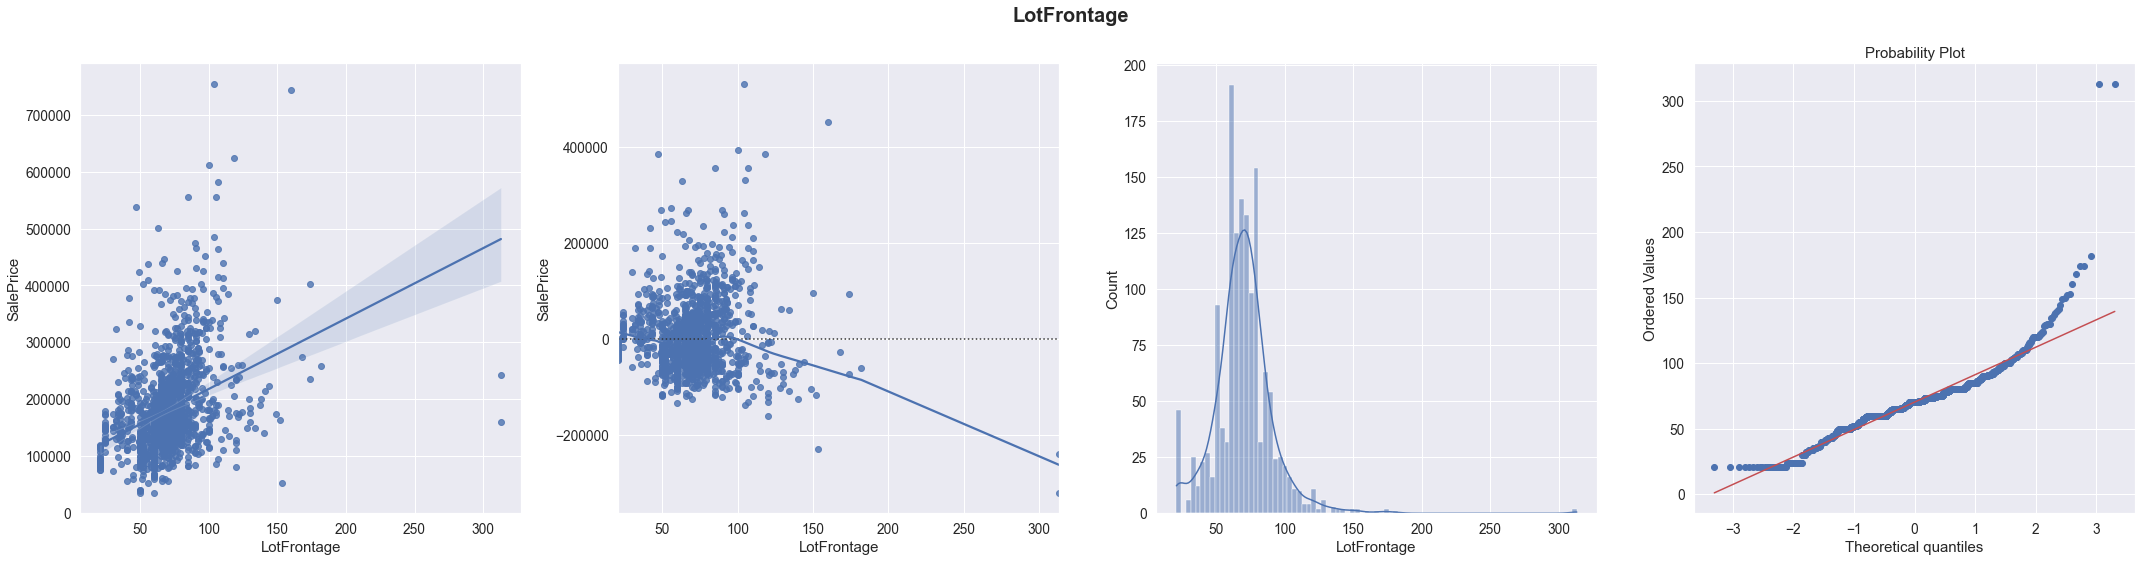

In [53]:
test_var_con(df_train['LotFrontage'],df_train['SalePrice'])

##### TotRmsAbvGrd

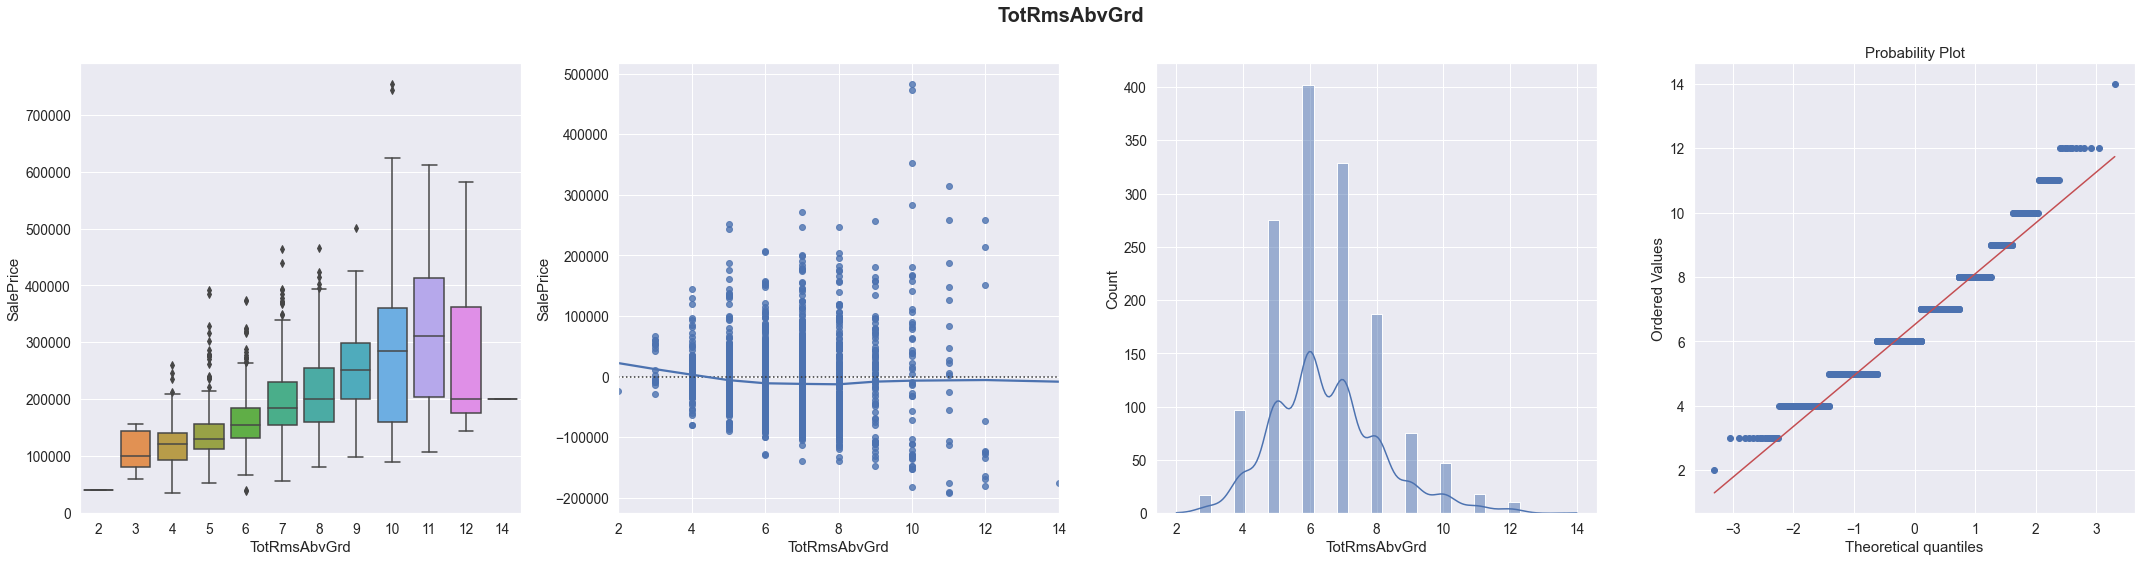

In [75]:
test_var_cat(df_train['TotRmsAbvGrd'],df_train['SalePrice'],rank=True)

TotRmsAbvGrd o habitaciones por encima del nivel del suelo. Es una variable con alta linealidad y homogeneidad, ademas la distribucion de los datos es muy parecida a una normal a pesar de ser datos discretos.

Presenta multicolinealidad con GrLivArea

##### GarageType

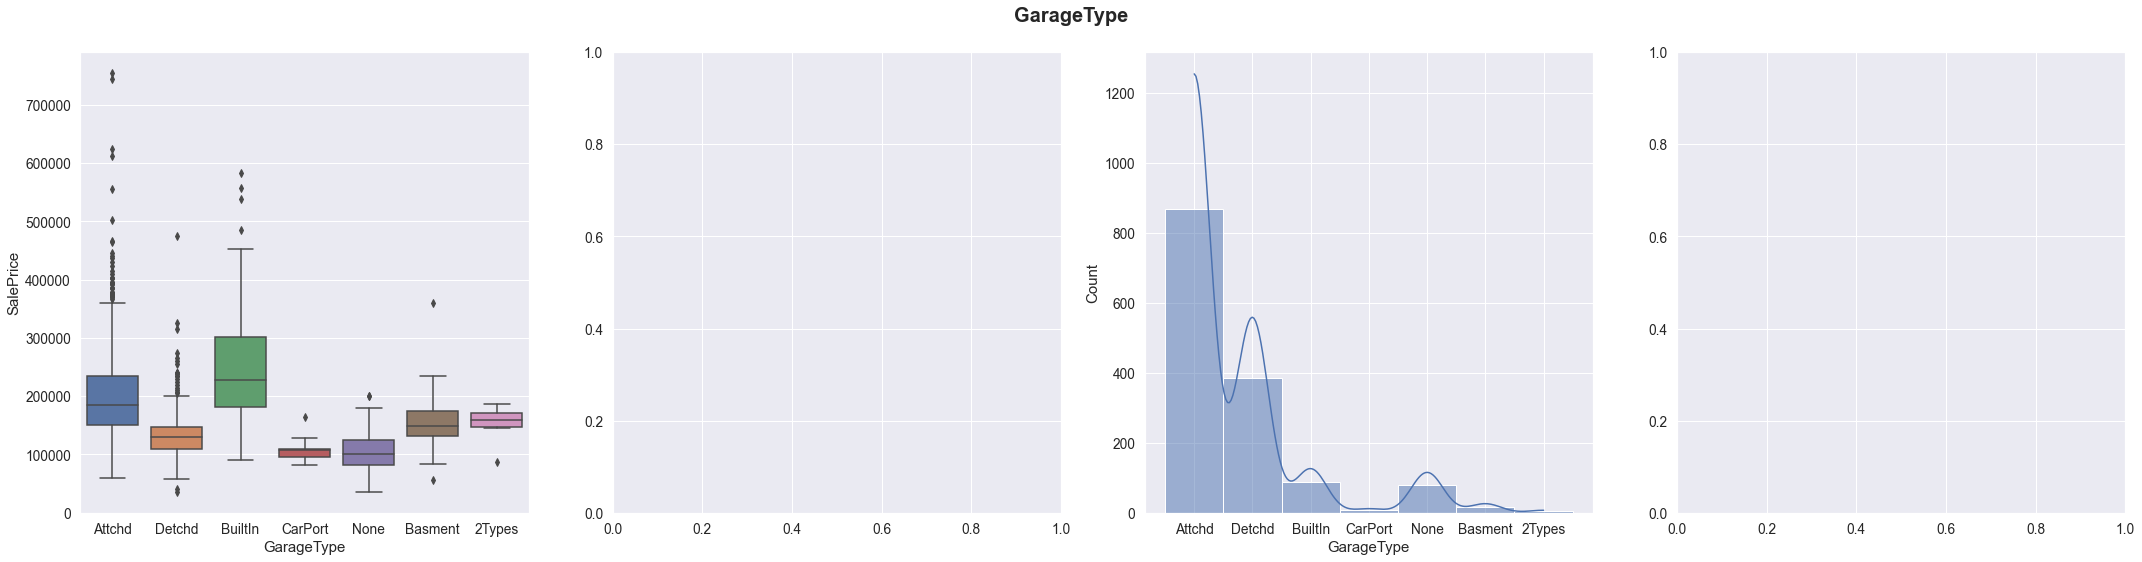

In [55]:
test_var_cat(df_train['GarageType'],df_train['SalePrice'])

##### FireplaceQu

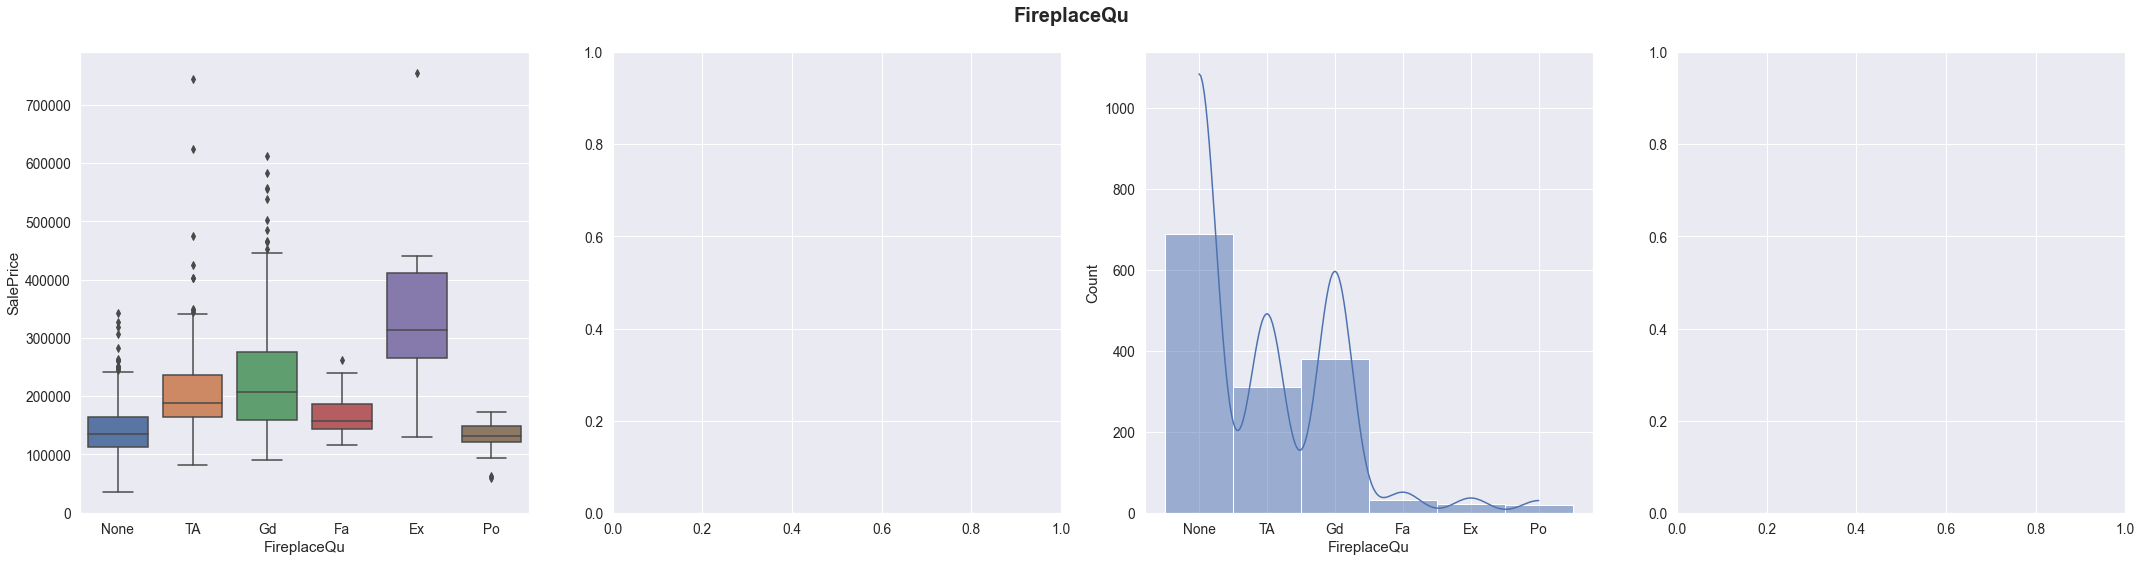

In [56]:
test_var_cat(df_train['FireplaceQu'],df_train['SalePrice'],rank=False)

FireplaceQu para los casos de Fa,Po y Ex se tiene una buena discriminacion

##### YearRemodAdd

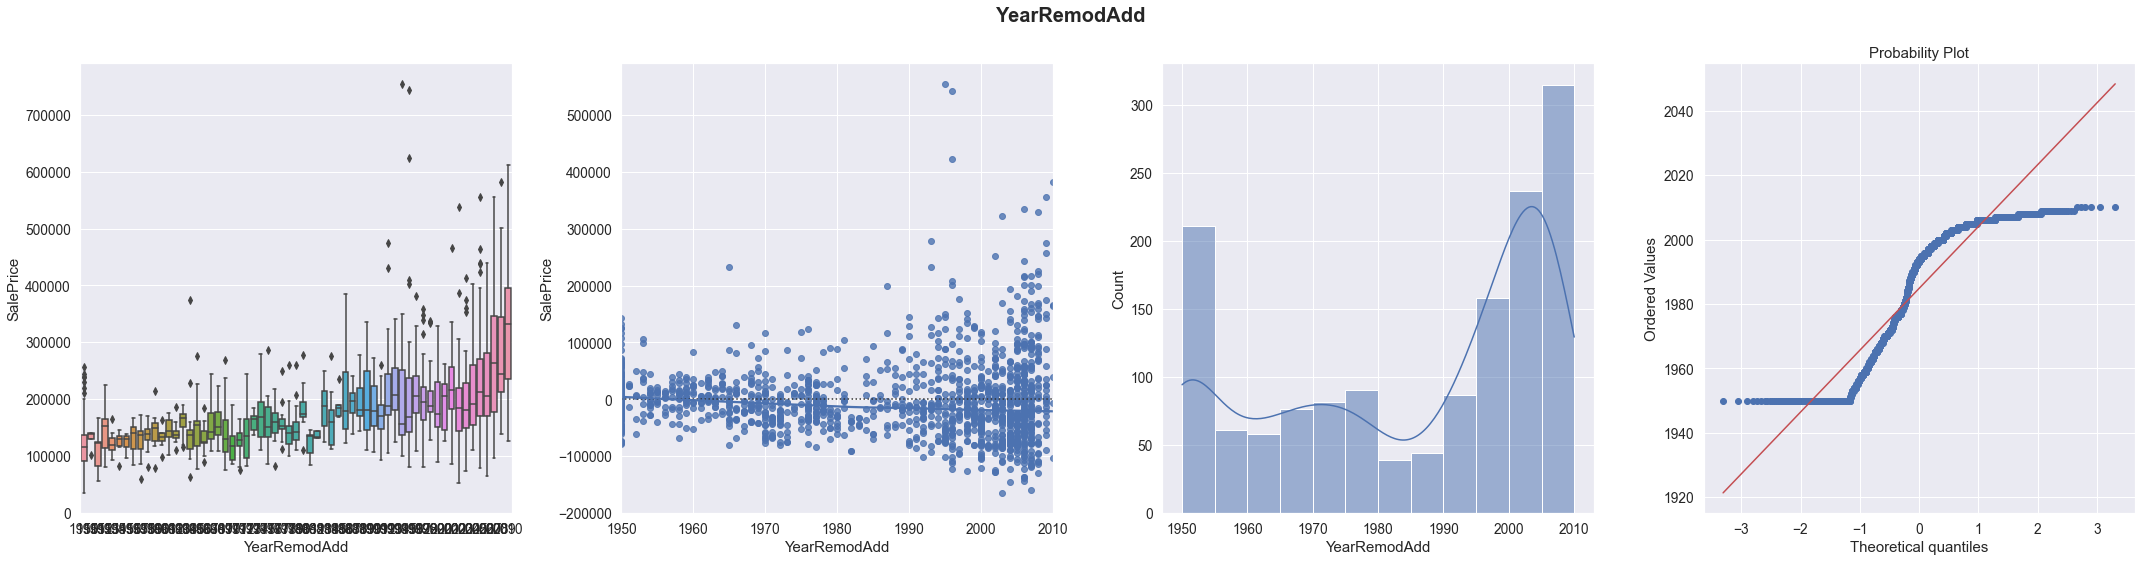

In [57]:
test_var_cat(df_train['YearRemodAdd'],df_train['SalePrice'],rank=True)

YearRemodAdd solo tiene datos desde 1950 y presenta un pequeño sesgo hacia ese año, posiblemente no se tenia el dato exacto y se aproximo. Tambien hay un sesgo hacia los datos despues del año 2000.Y se tiene linealidad y homogenidad despues del año 1980

##### 2ndFlrSF

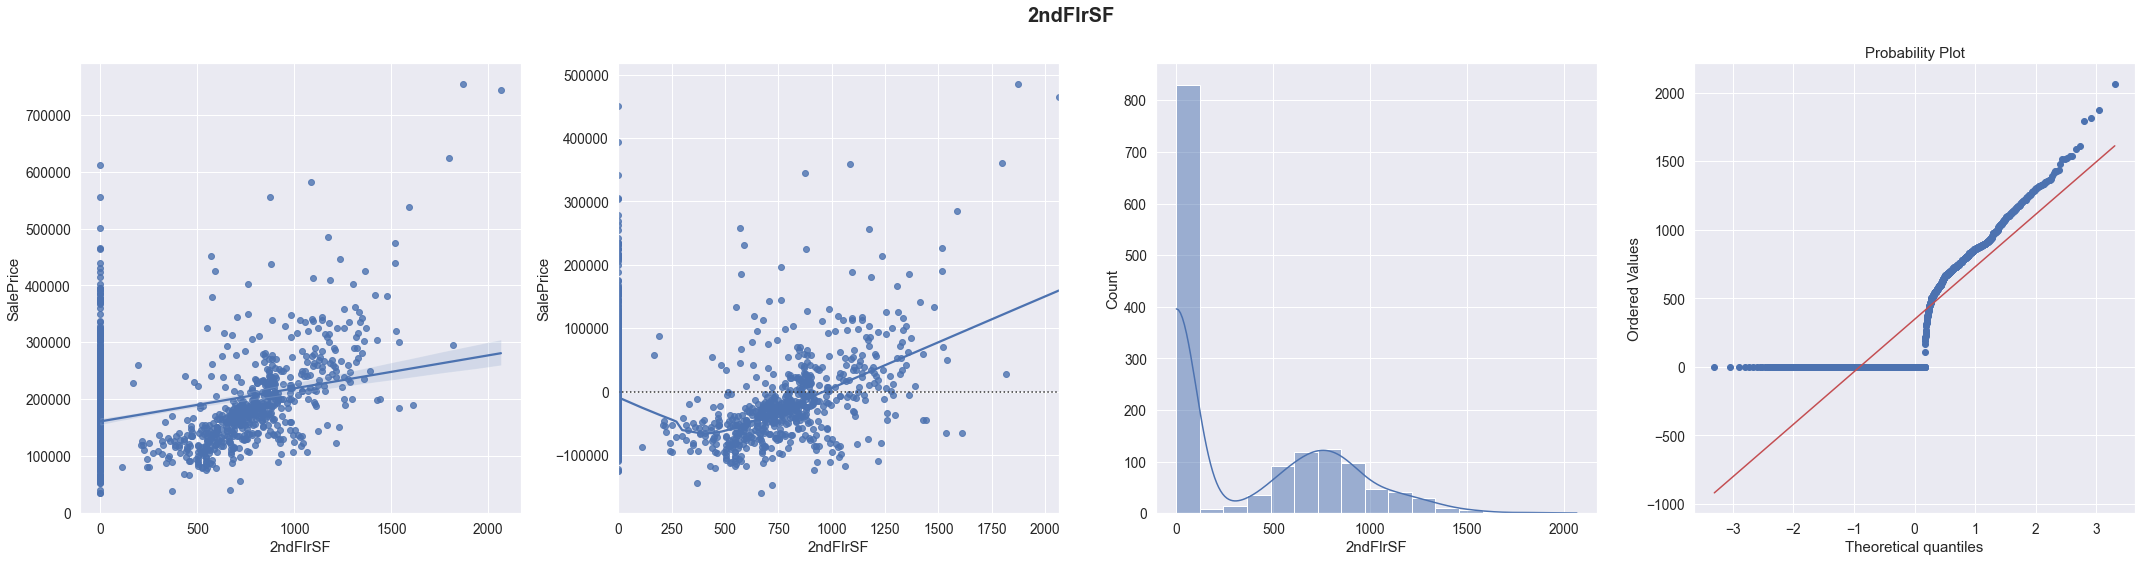

In [59]:
test_var_con(df_train['2ndFlrSF'],df_train['SalePrice'])

2ndFlrSF o area del segundo piso en ft. Tiene un sesgo hacia 0 por lo cual hay muchas casas de un solo piso, se podria hacer un FE

Presenta multicolinealidad con GrLivArea

##### Foundation

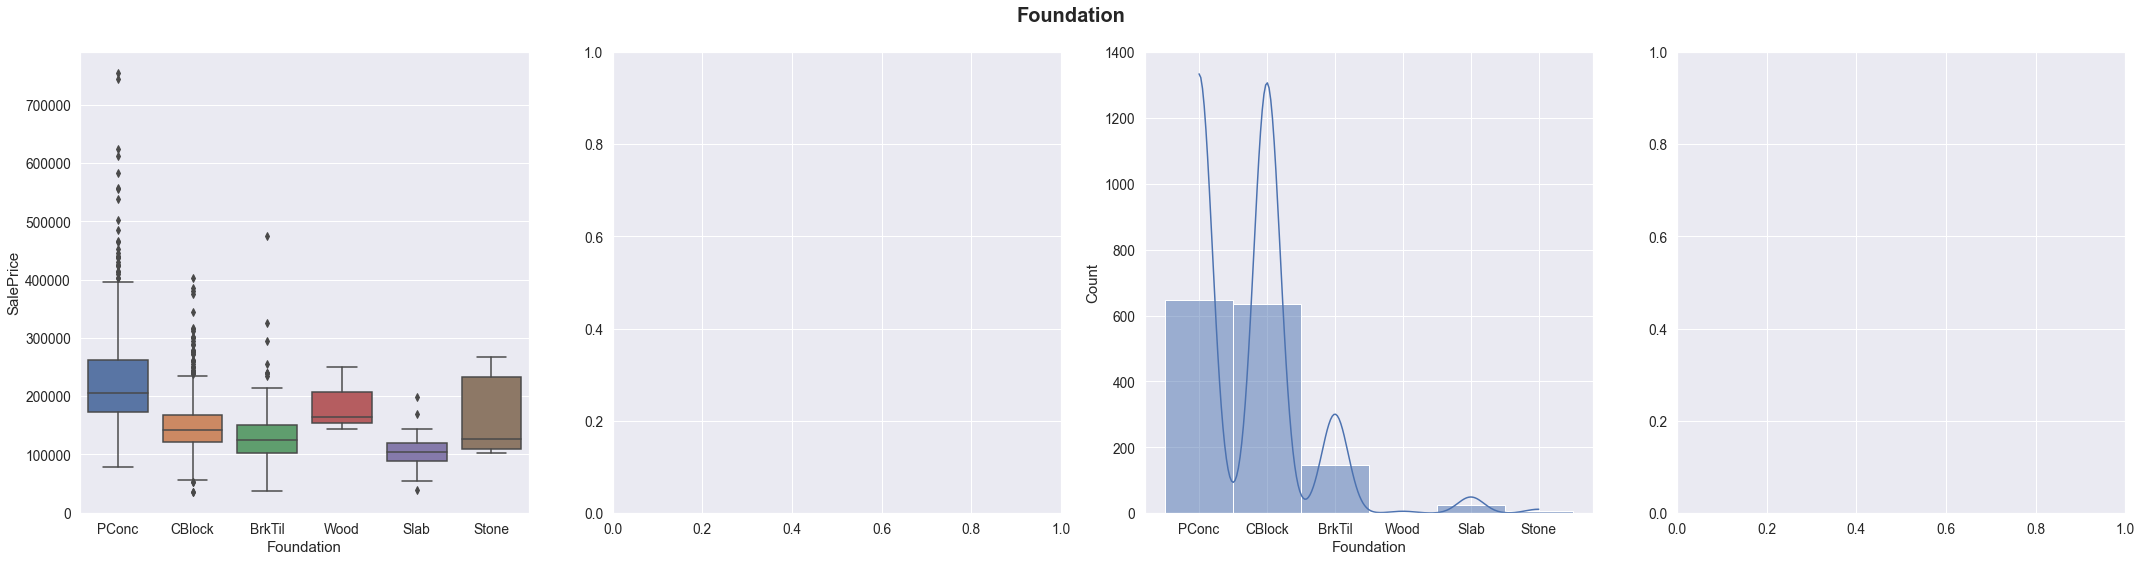

In [58]:
test_var_cat(df_train['Foundation'],df_train['SalePrice'])

Foundation o tipo de cimientos tiene una relacion lineal aunque no presenta una gran pendiente o sensibilidad, ademas las casas con cimientos en piedra tienen un gran rango intercuartil

##### Fireplaces

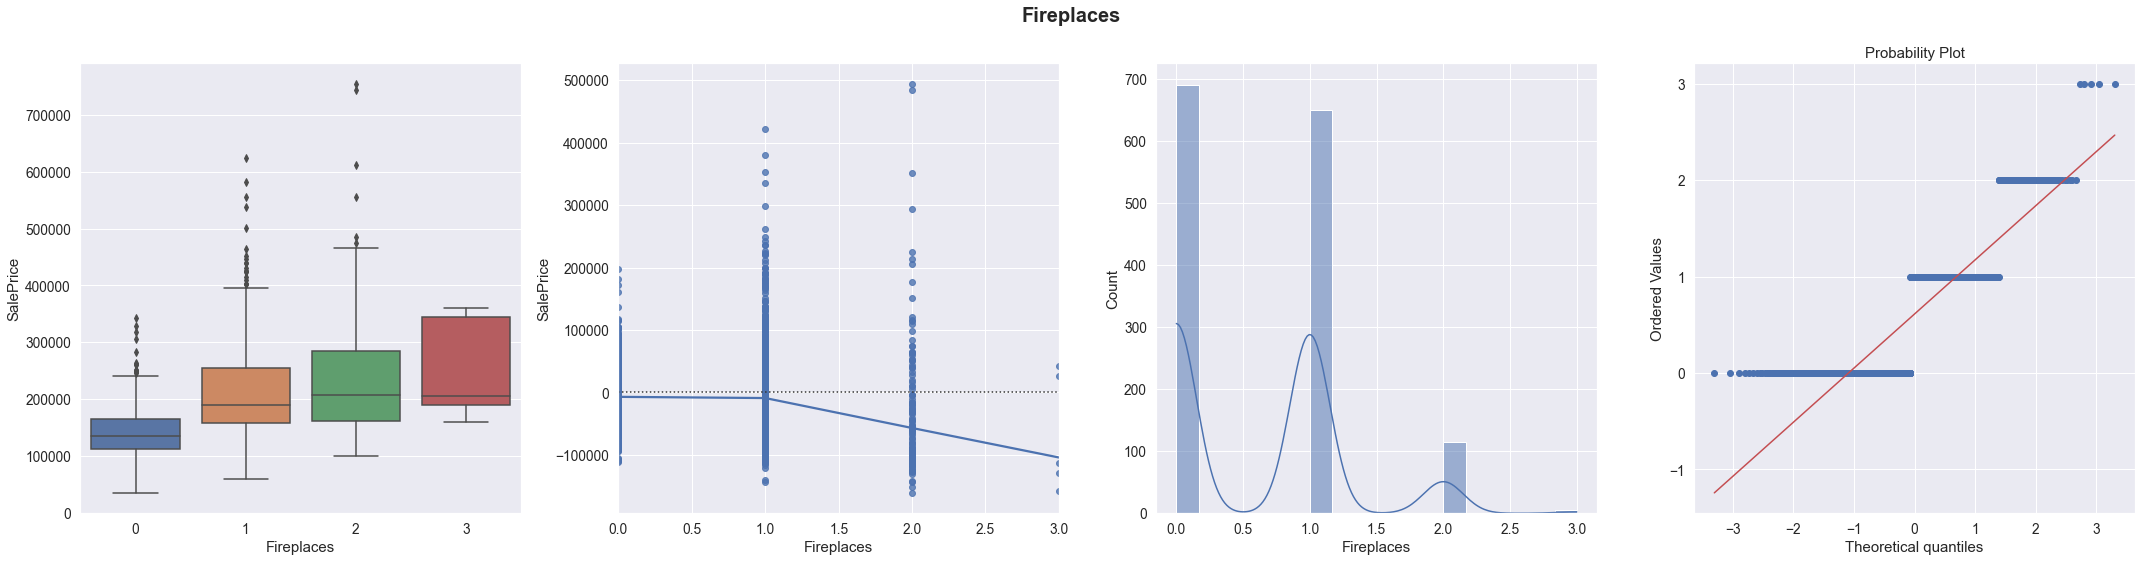

In [60]:
test_var_cat(df_train['Fireplaces'],df_train['SalePrice'],rank=True)

Fireplaces o numero de chimeneas, sus valores mas comunes son 0 o 1, la mayor discriminacion se presenta entre tener o no tener chimenea, por lo cual se podria intentar simplificar esta variable.


##### Exterior2nd

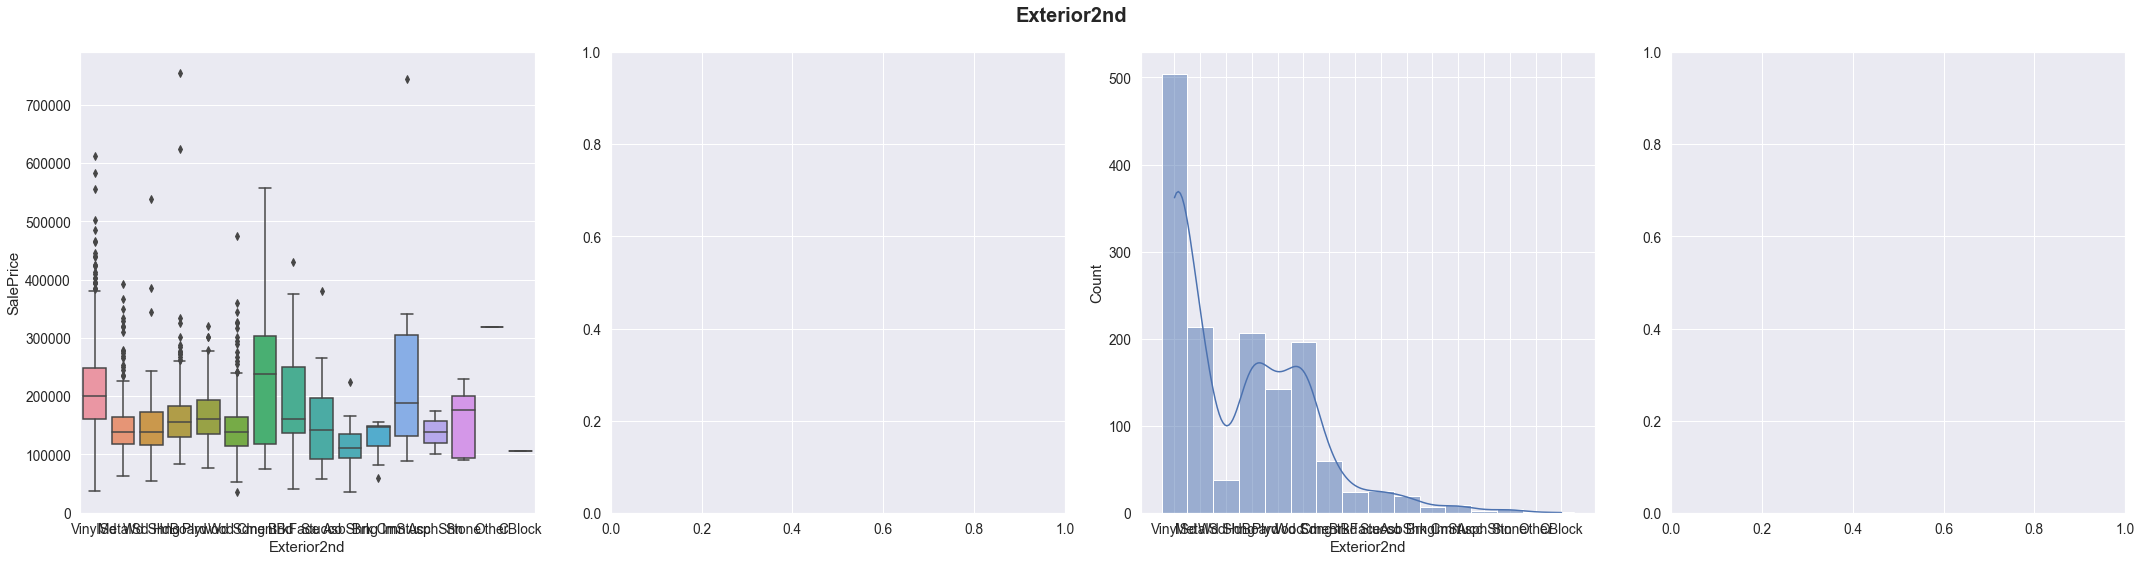

In [61]:
test_var_cat(df_train['Exterior2nd'],df_train['SalePrice'])

##### LotArea

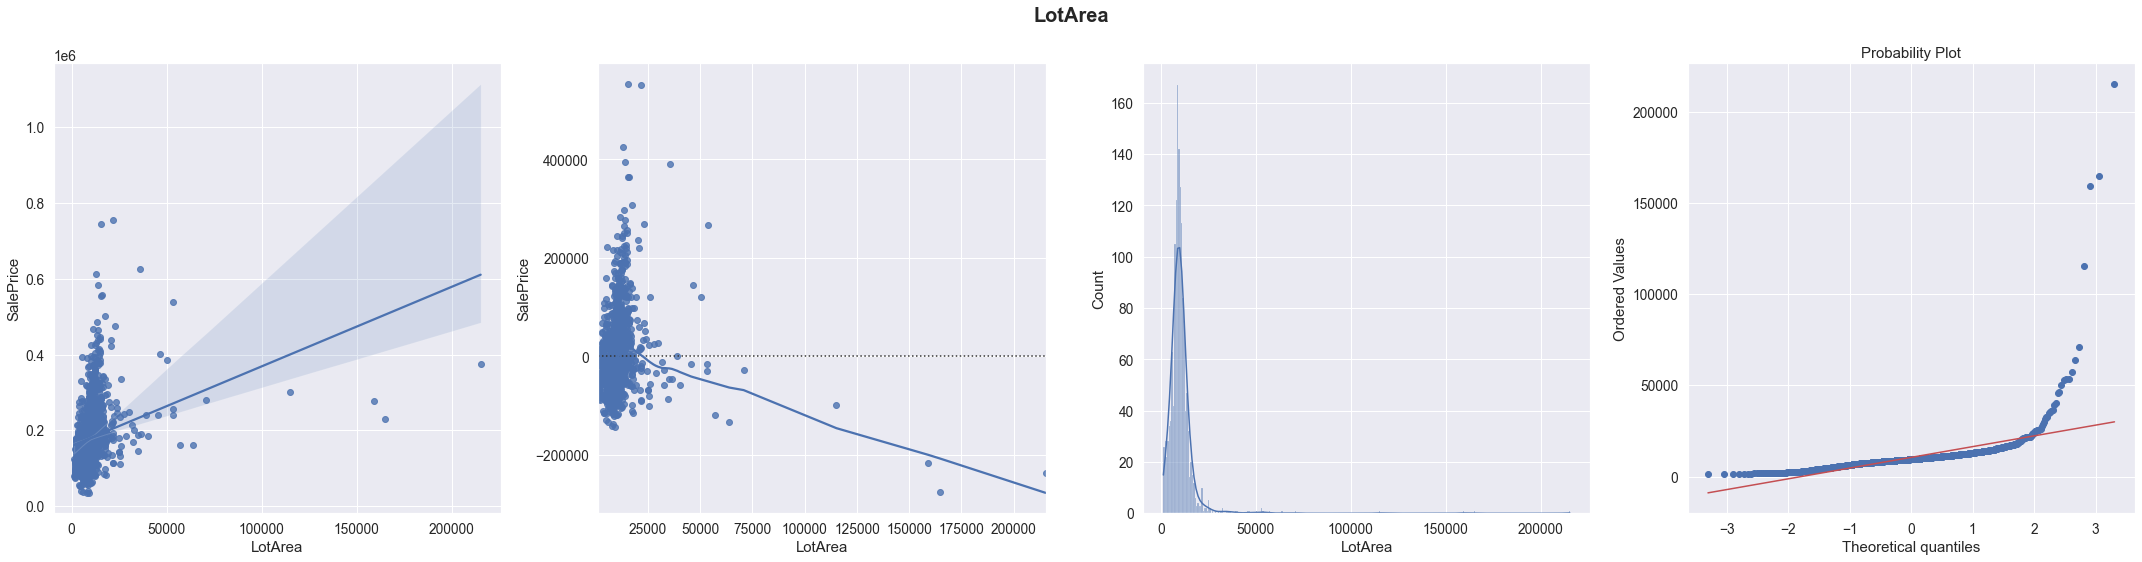

In [62]:
test_var_con(df_train['LotArea'],df_train['SalePrice'])

##### BsmtFinType1

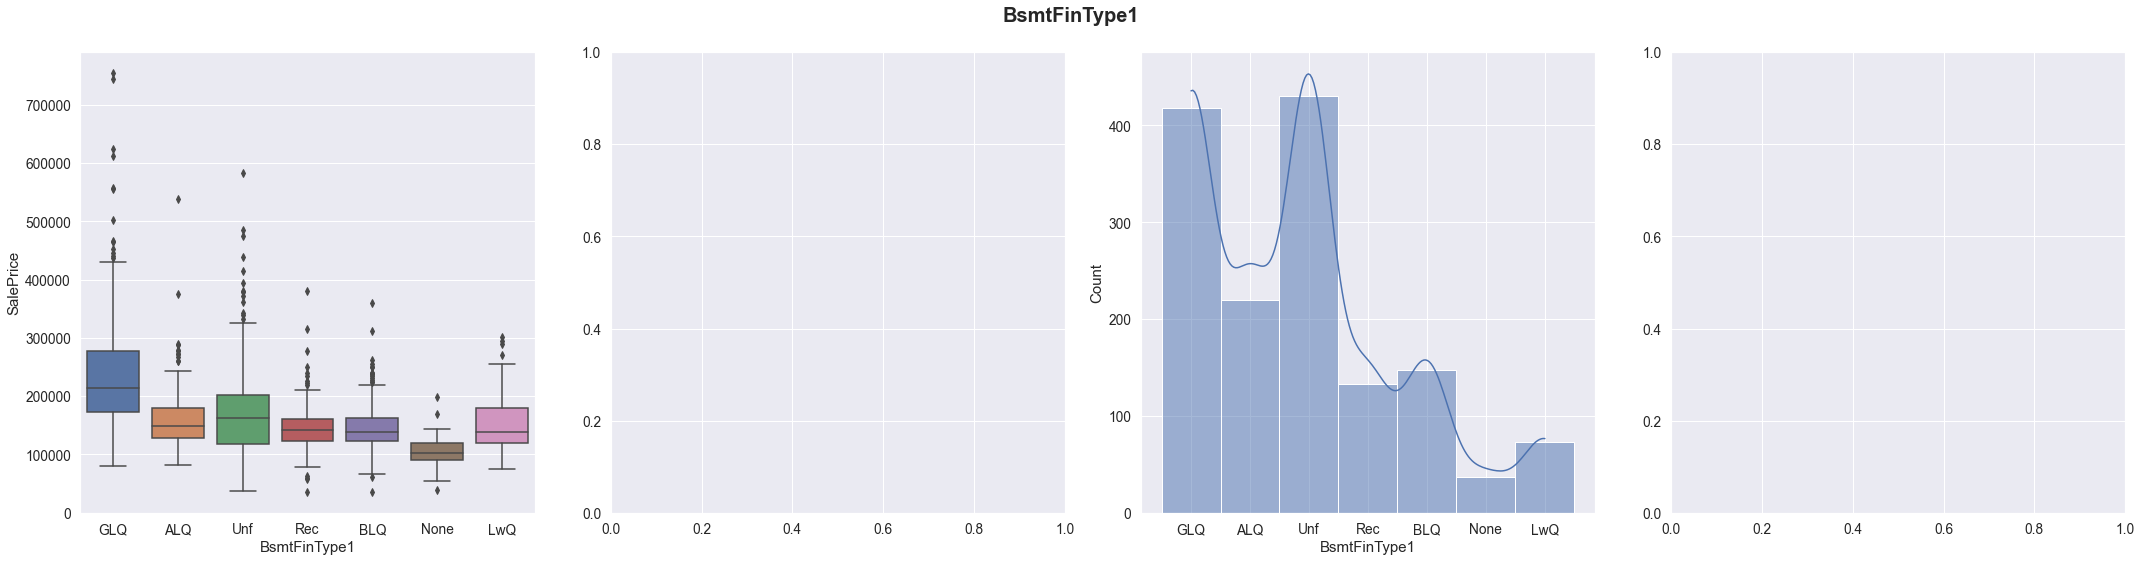

In [63]:
test_var_cat(df_train['BsmtFinType1'],df_train['SalePrice'])

##### HeatingQC

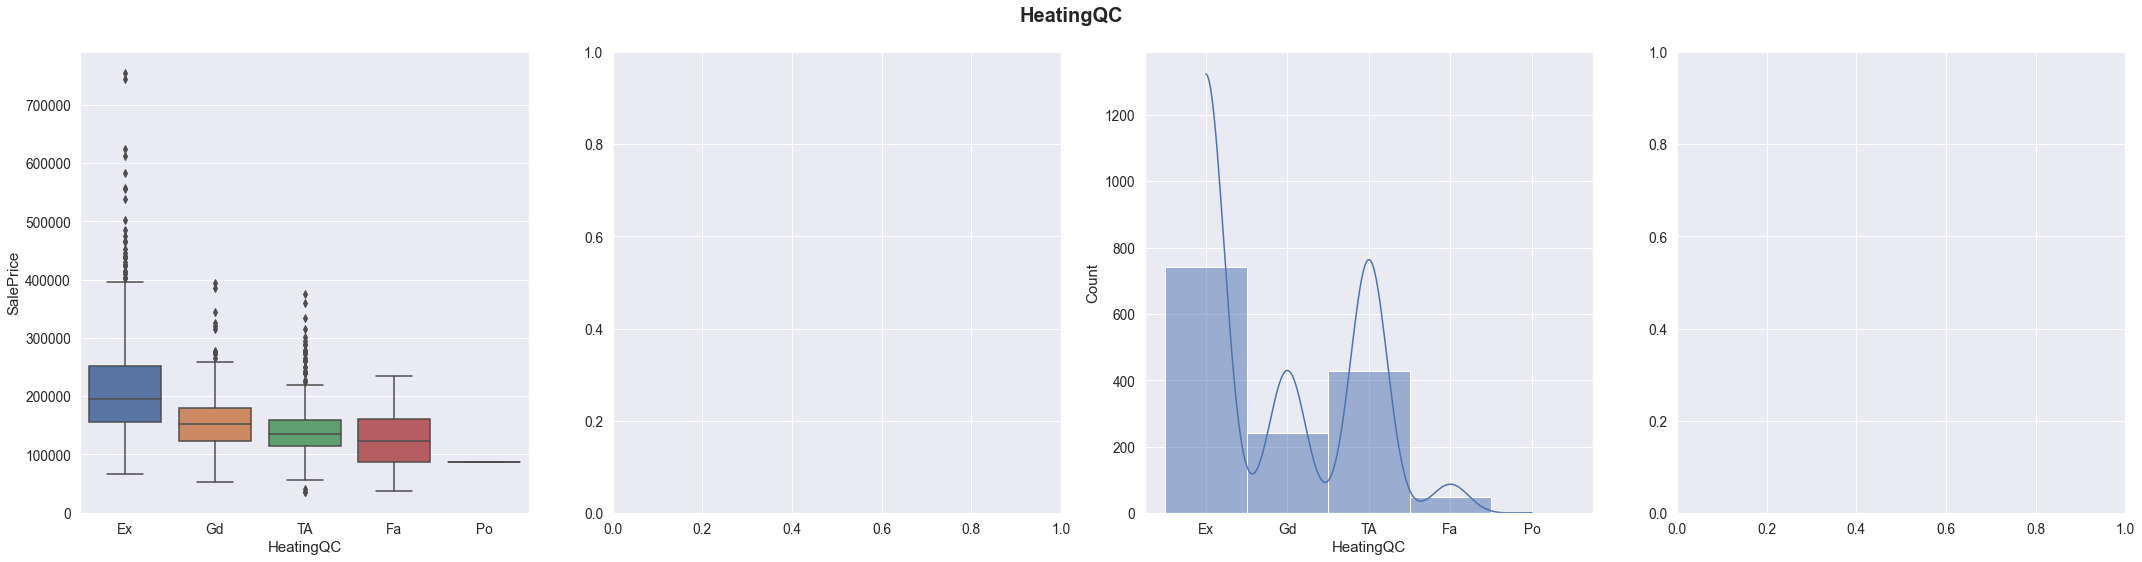

In [64]:
test_var_cat(df_train['HeatingQC'],df_train['SalePrice'])

HeatingQC o calidad de la calefaccion tiene una linealidad alta

#### YearBuilt

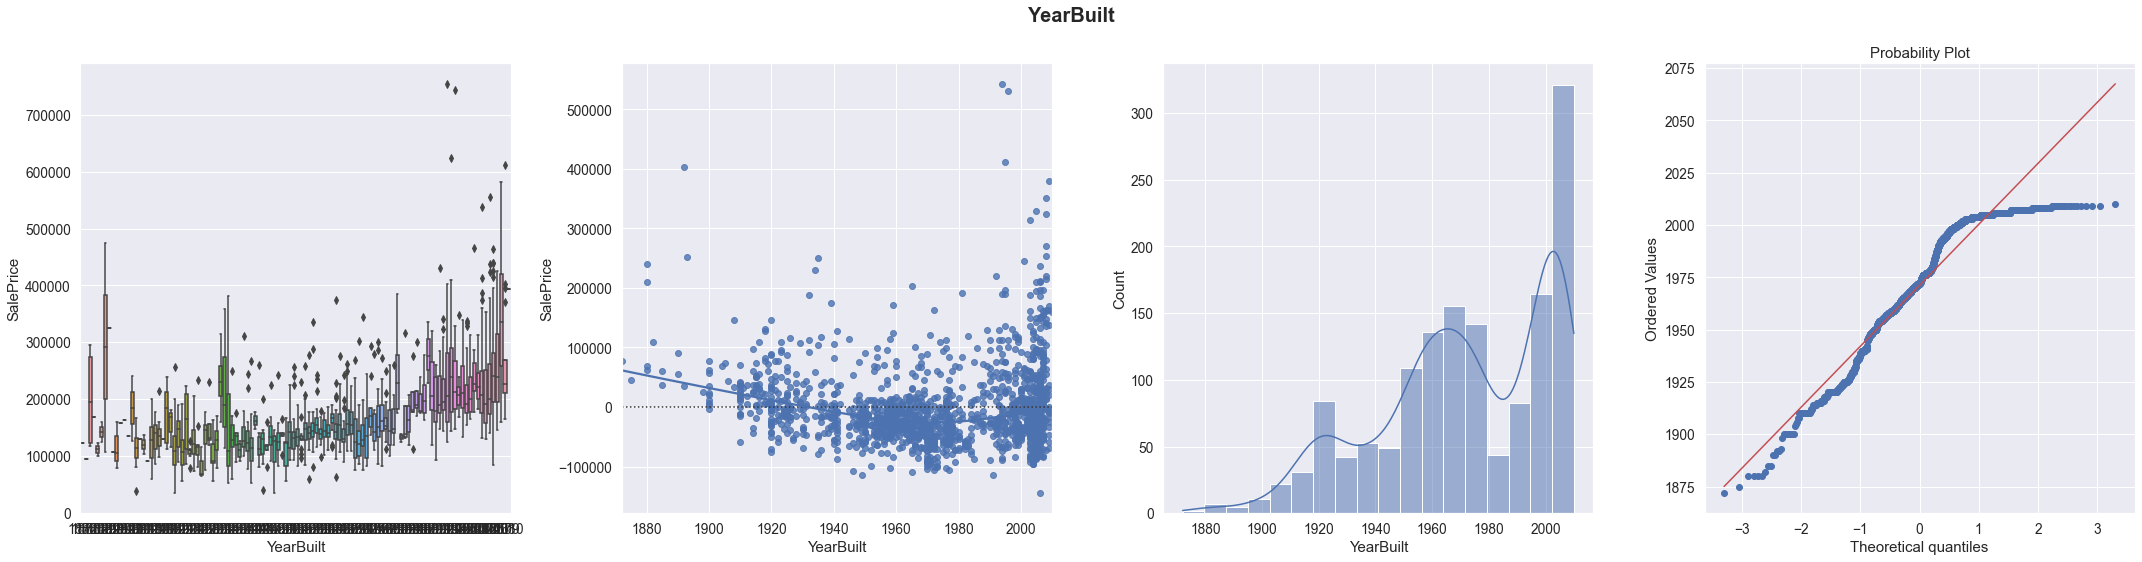

In [234]:
test_var_cat(df_train['YearBuilt'],df_train['SalePrice'],rank=True)

El año de construccion presenta una distribucion parecida a una normal pero sesgada hacia la derecha, supongo que se debe a un crecimiento del sector immobiliario ademas de la conocina burbuja immobiliaria del 2008. se tiene una relacion casi lineal y homogeneidad principalmente para los años 1950

##### OpenPorchSF

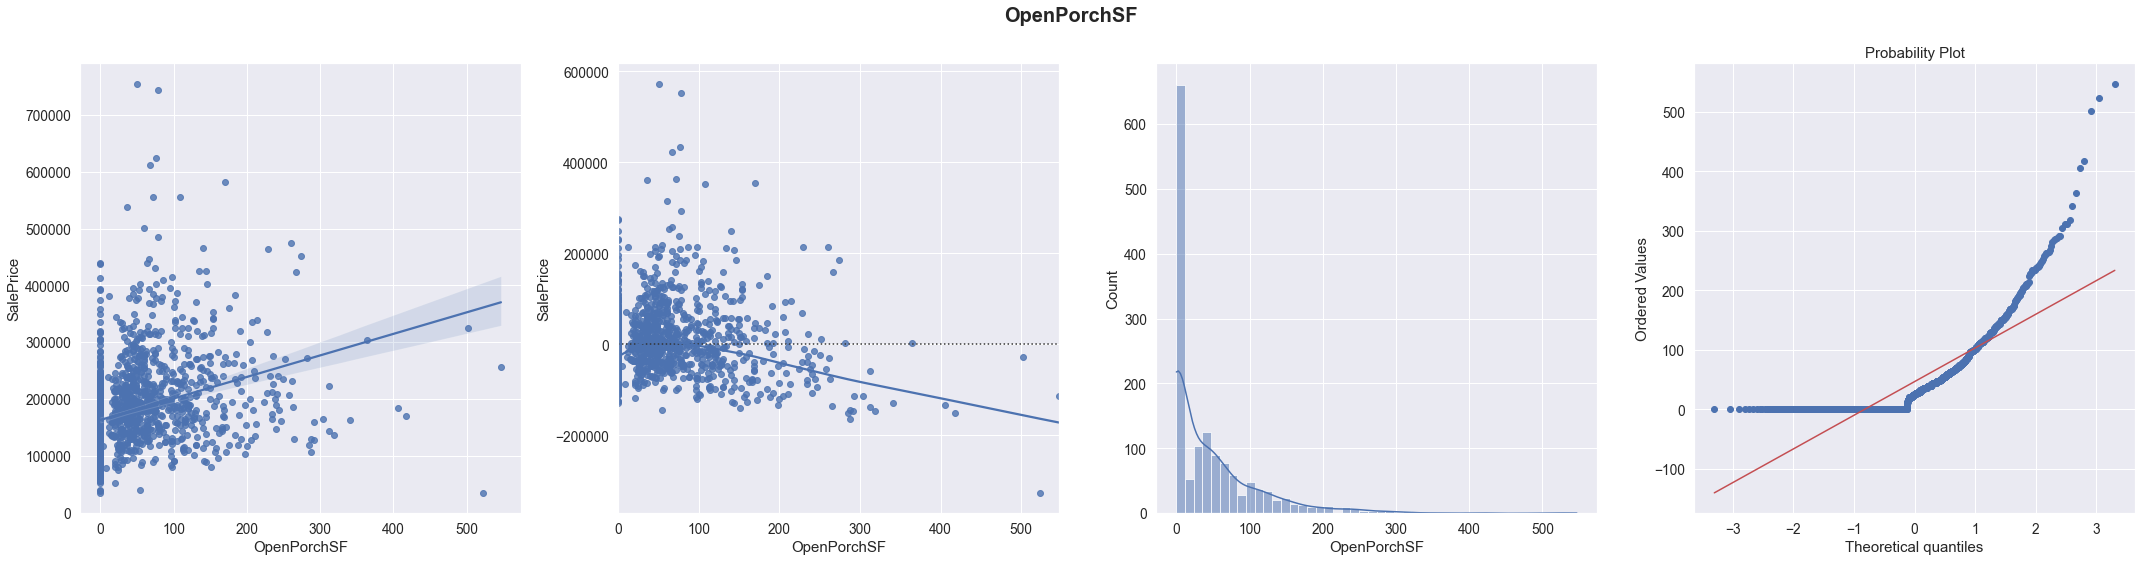

In [67]:
test_var_con(df_train['OpenPorchSF'],df_train['SalePrice'])

##### BsmtFinSF1

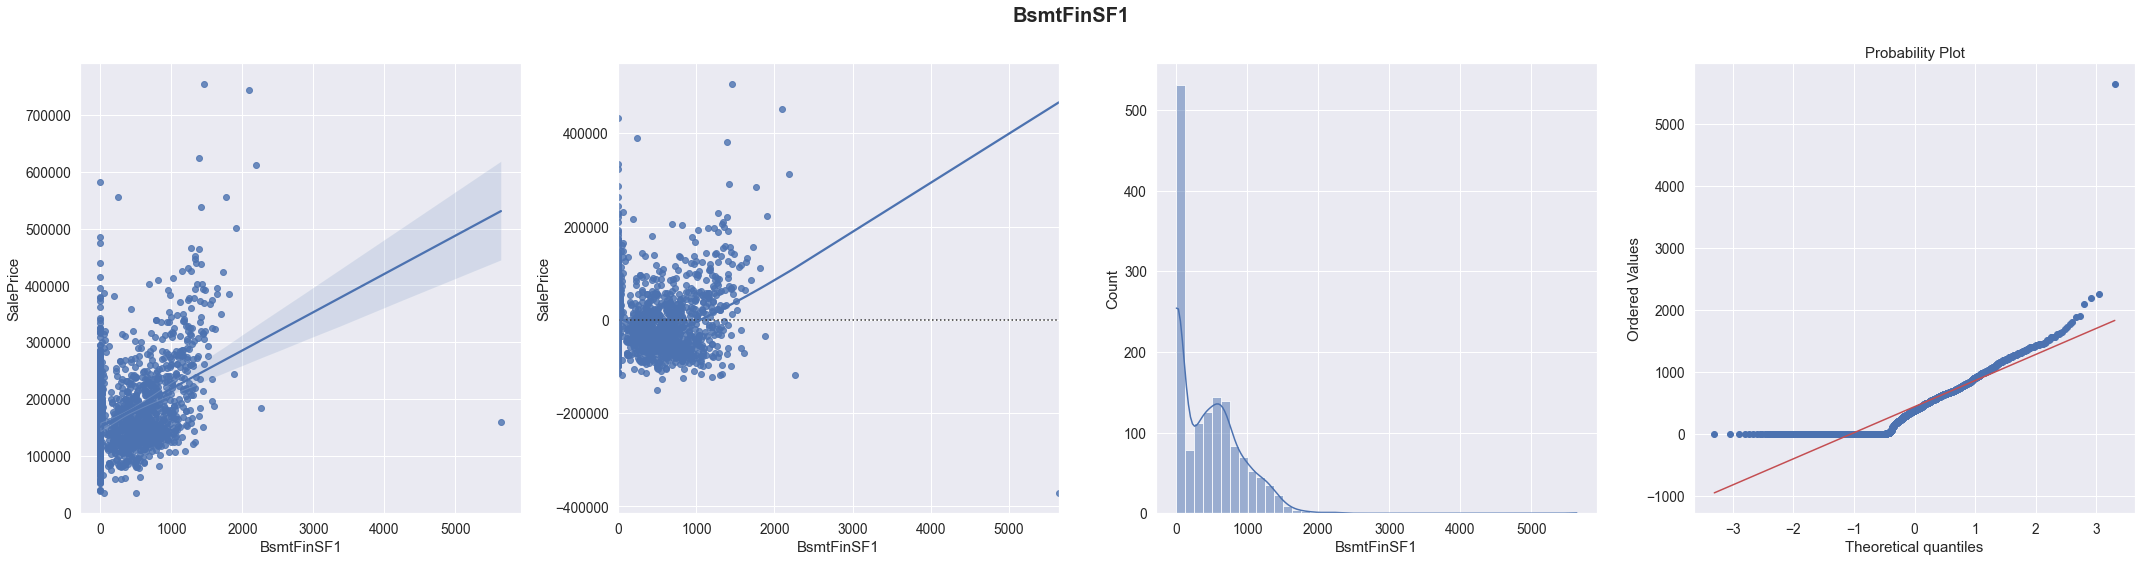

In [66]:
test_var_con(df_train['BsmtFinSF1'],df_train['SalePrice'])

BsmtFinSF1 o Area del sotano terminado en ft. Tiene un sesgo muy grande al 0 y cierta linealidad y normalidad en los valores mayores a 0

##### MSZoning

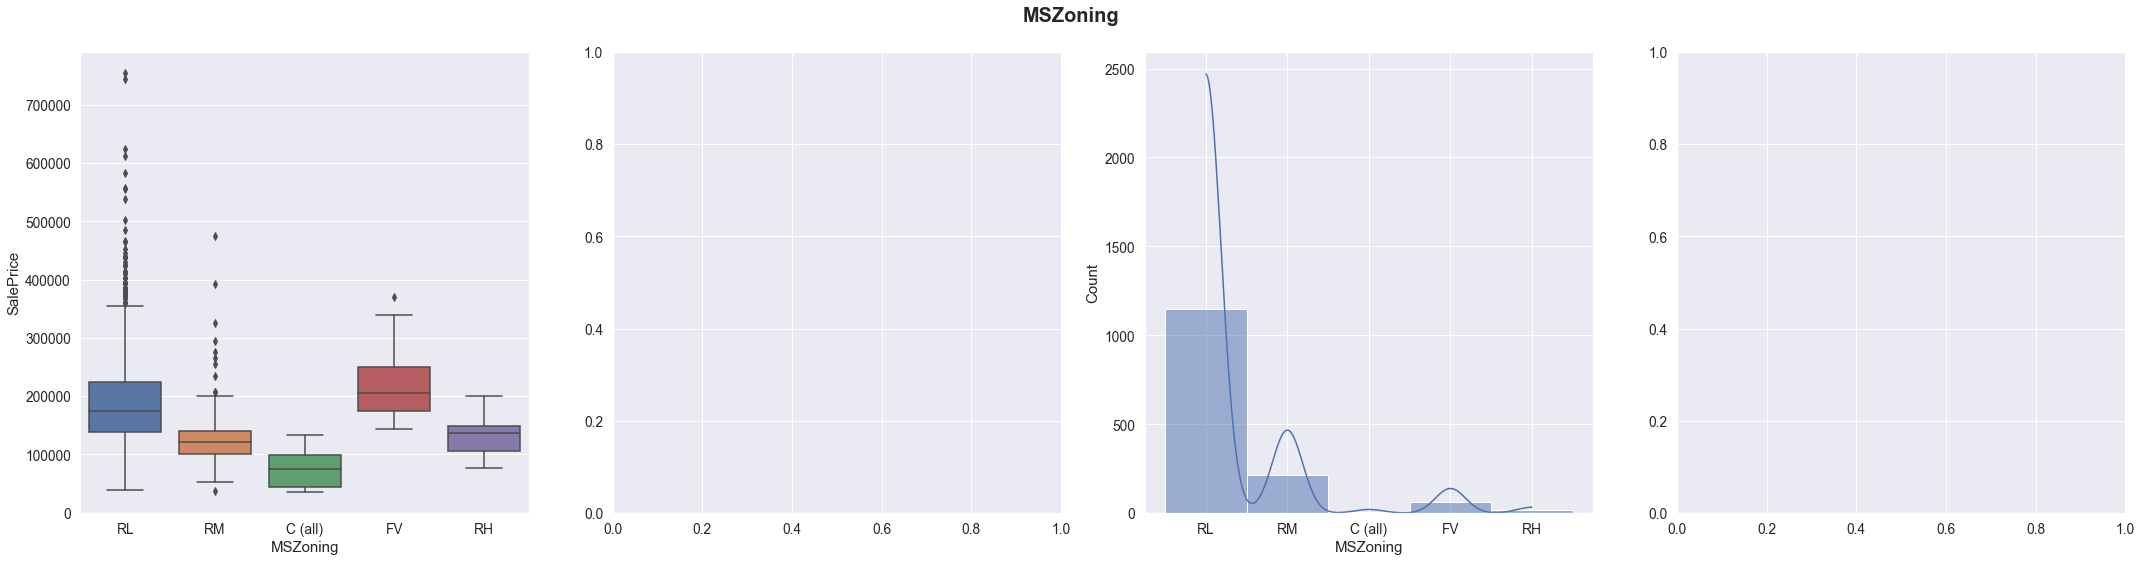

In [65]:
test_var_cat(df_train['MSZoning'],df_train['SalePrice'])

MSZoning o clasificacion de la zona, Presenta que en general ser una zona con poca densidad aumenta el precio de la casa, ademas este es el tipo de casa mas comun

##### Exterior1st

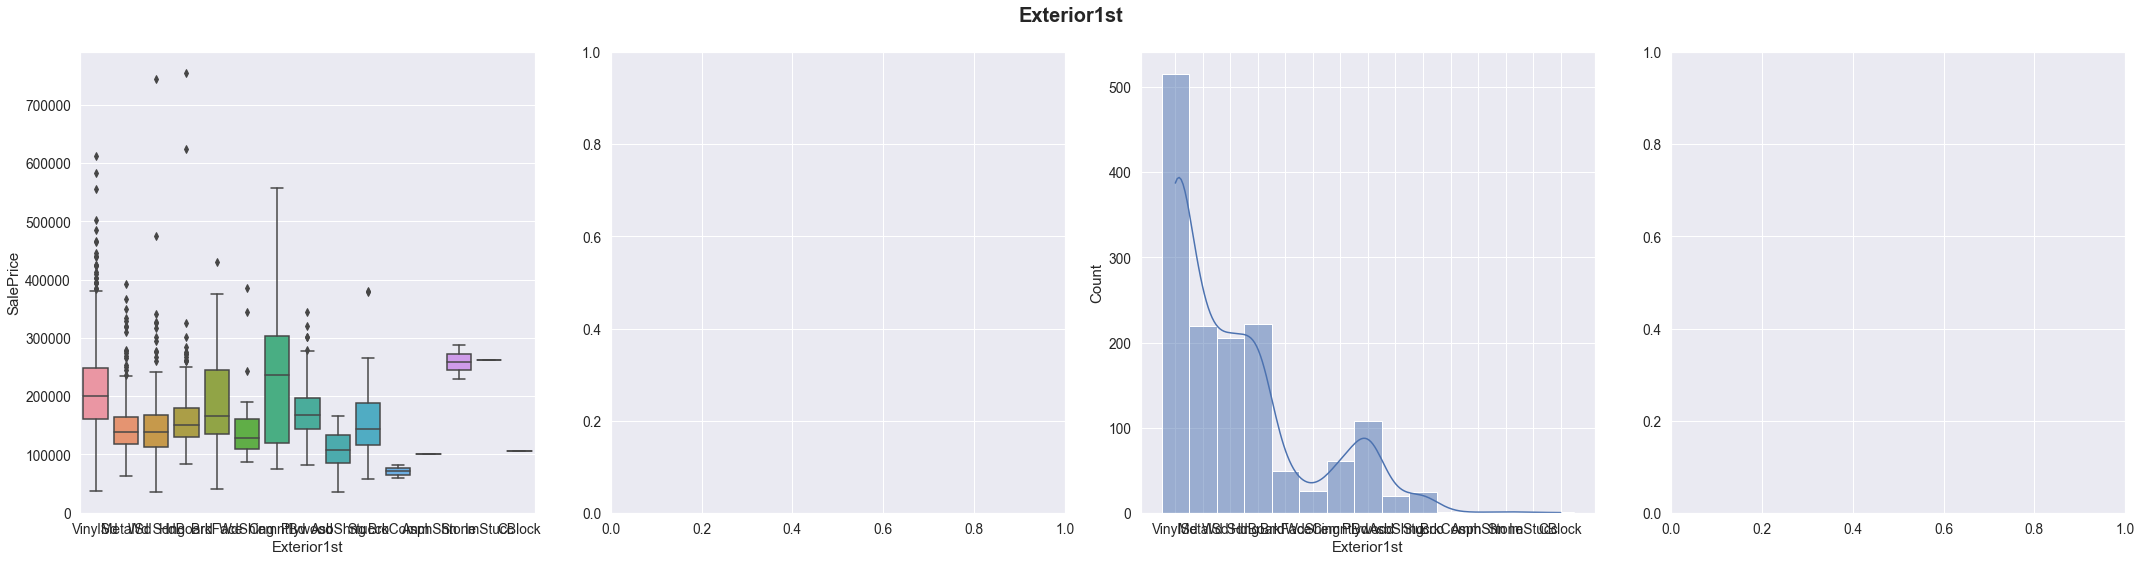

In [68]:
test_var_cat(df_train['Exterior1st'],df_train['SalePrice'])

##### BsmtUnfSF

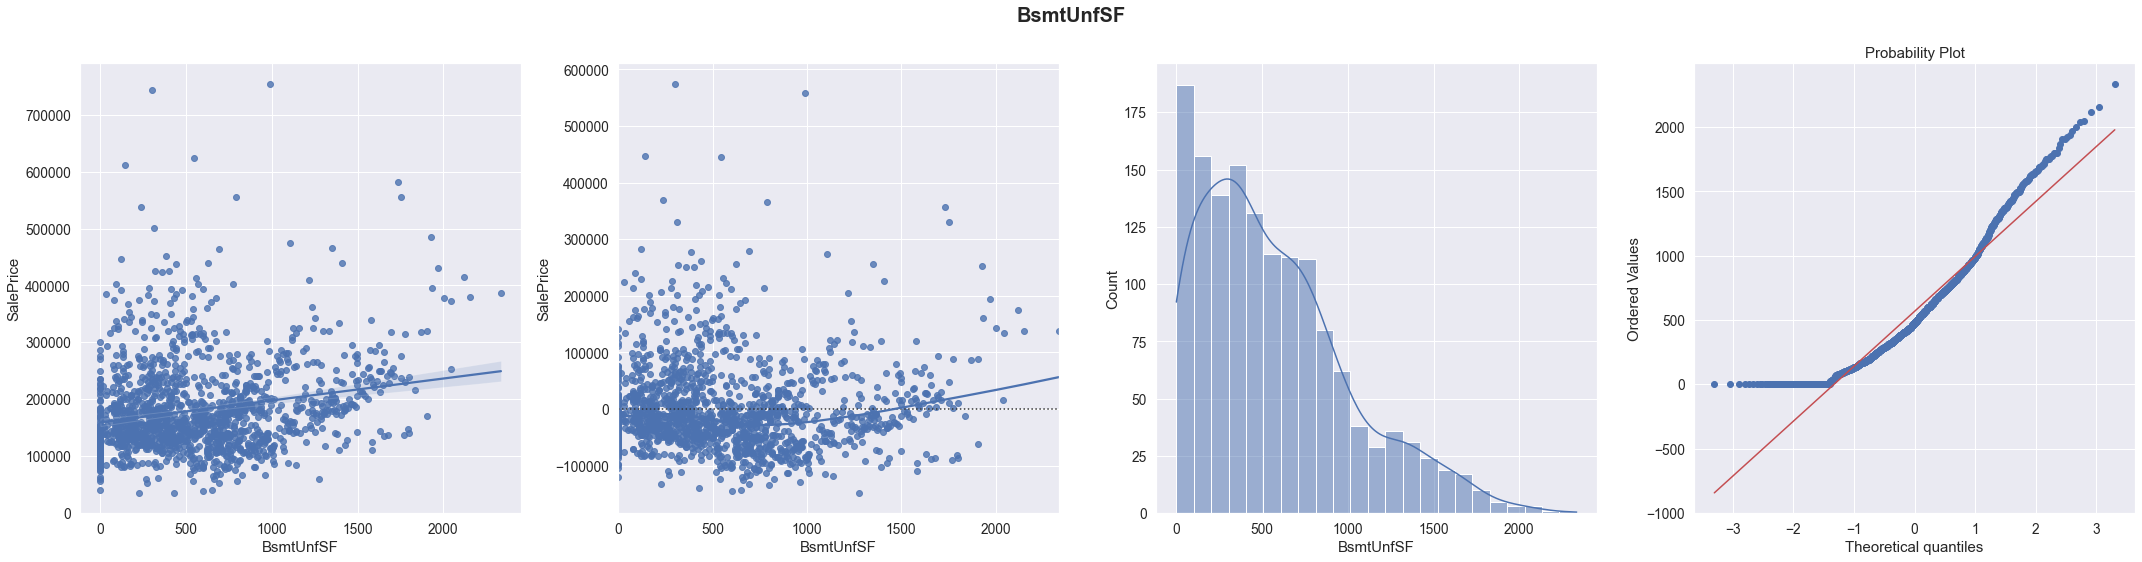

In [69]:
test_var_con(df_train['BsmtUnfSF'],df_train['SalePrice'])

##### WoodDeckSF

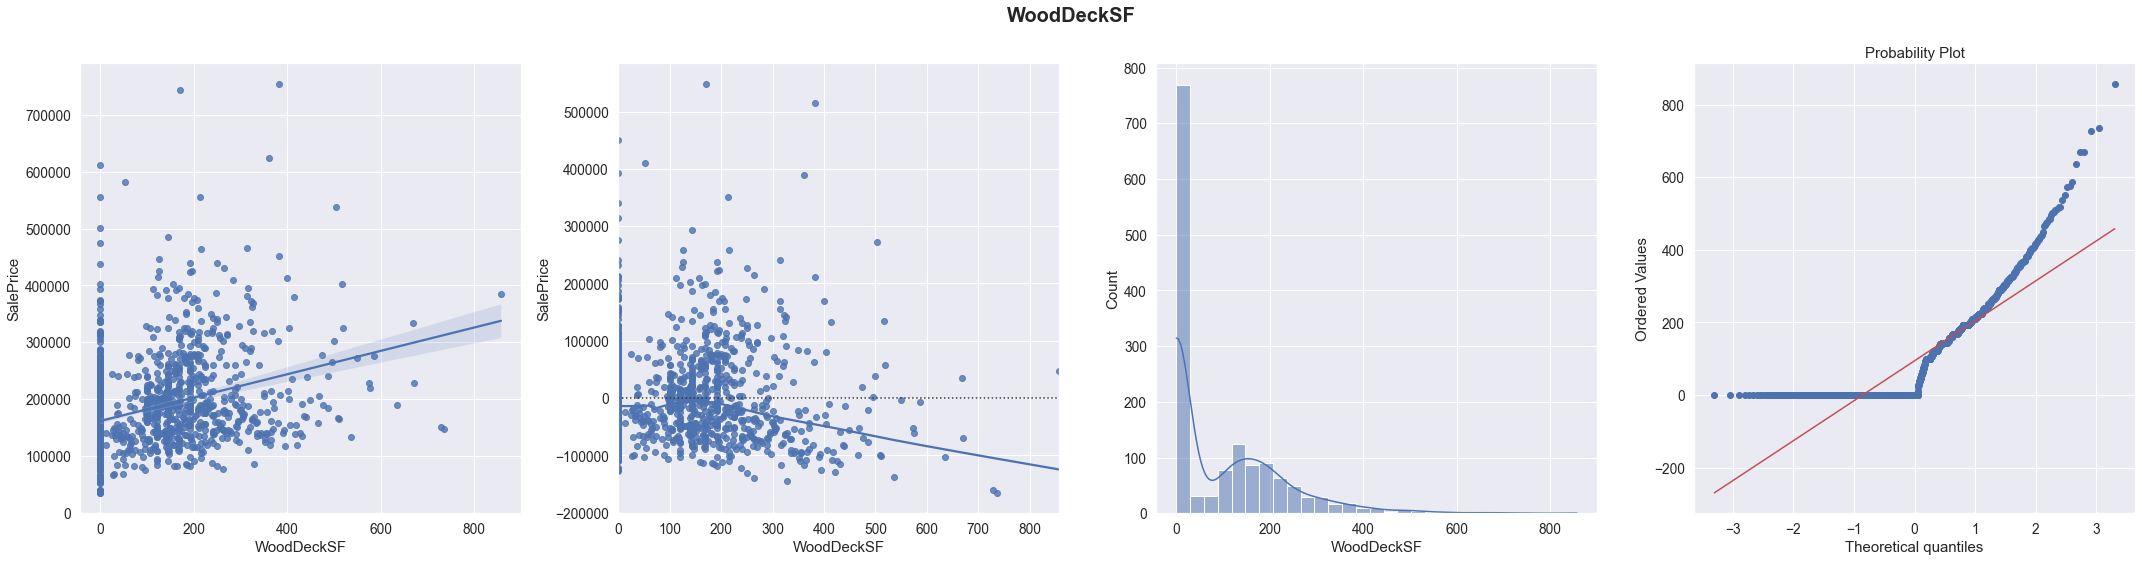

In [70]:
test_var_con(df_train['WoodDeckSF'],df_train['SalePrice'])

##### OverallCond

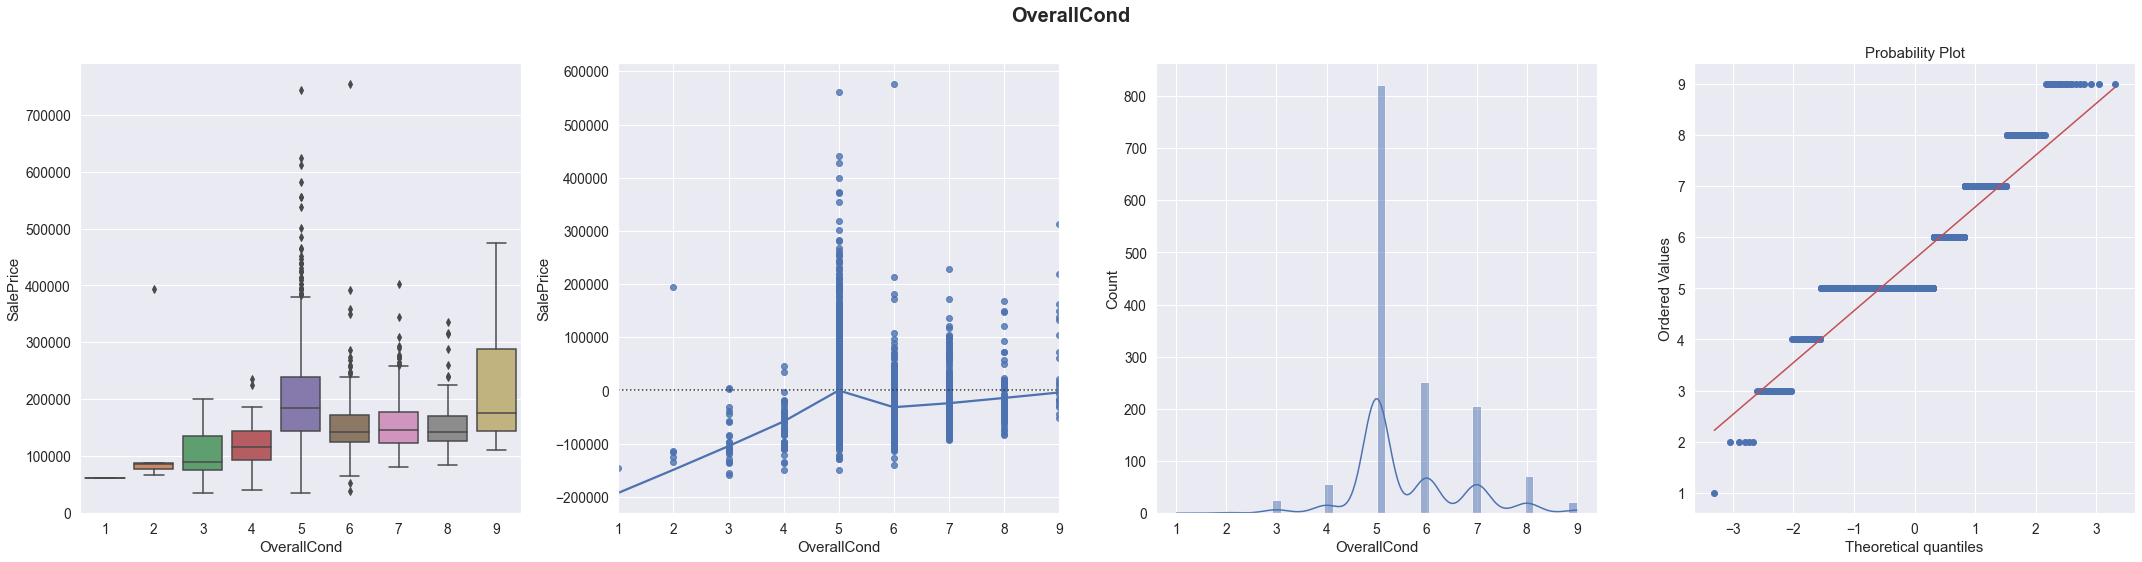

In [241]:
test_var_cat(df_train['OverallCond'],df_train['SalePrice'],rank=True)

OverallCond o condicion general de la casa, tiene una distribucion parecida a una normal y linealidad pero posee una pendiente baja

##### MasVnrType

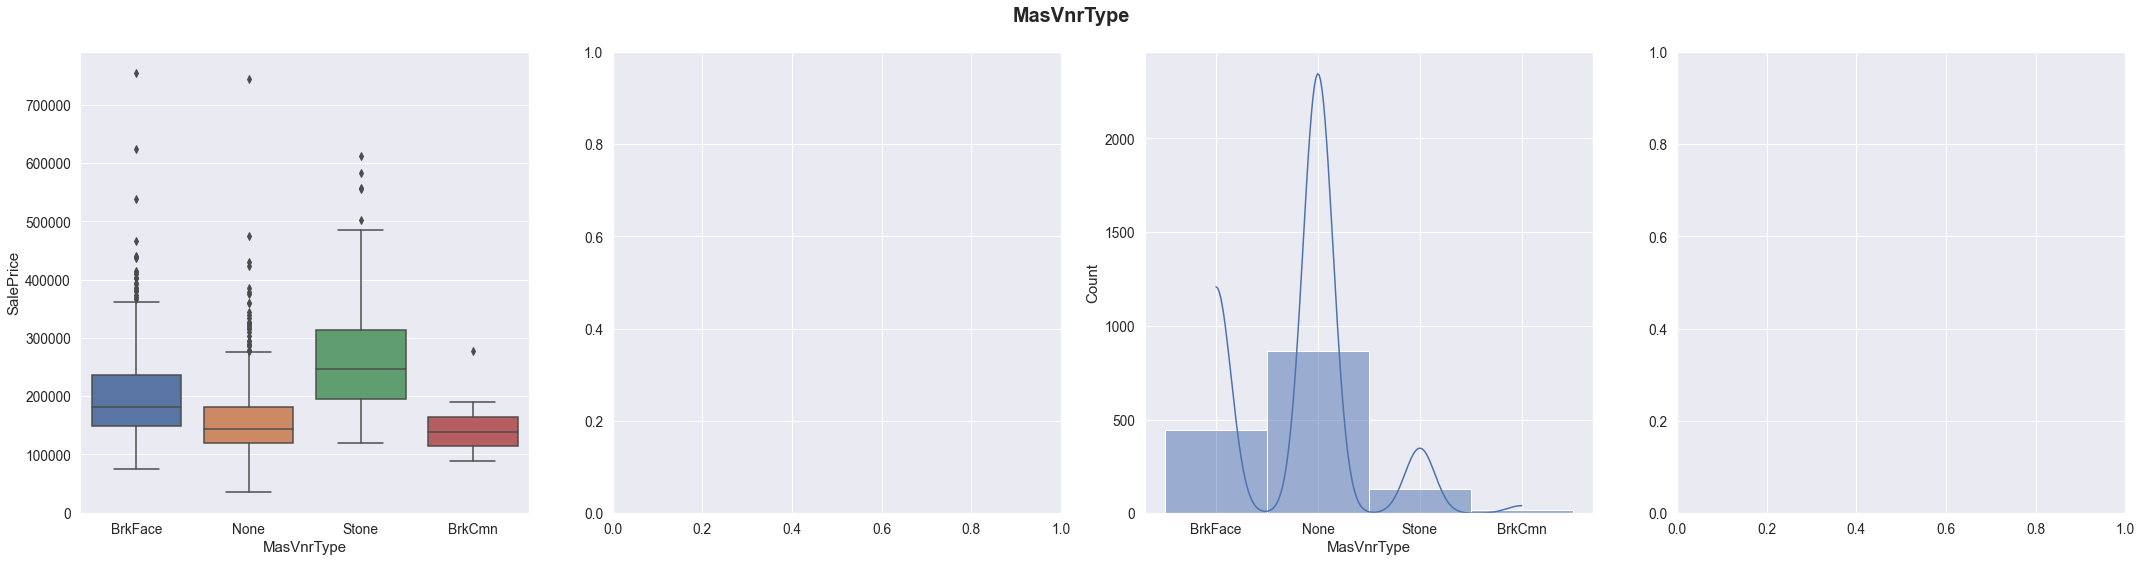

In [244]:
test_var_cat(df_train['MasVnrType'],df_train['SalePrice'])

MasVnrType o Chapa mamposteria (capa o muro externo no estructural), tiene los valores mas comunes en ninguno y presenta una diferencia significativa si es de piedra

##### Analisis Outliers

In [73]:
num_vars = df_train.columns[df_train.dtypes != 'object']
df_train_bdscan=df_train[num_vars]
df_train_bdscan_scaled= pd.DataFrame(StandardScaler().fit_transform(df_train_bdscan),columns=num_vars)

##### Hallando Epsilon

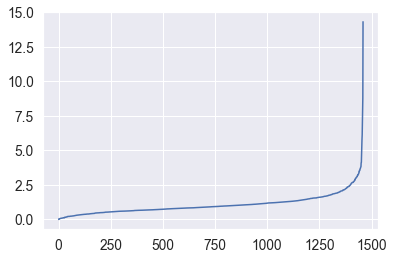

In [89]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_train_bdscan_scaled)
distances, indices = nbrs.kneighbors(df_train_bdscan_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Del grafico de codo podemos ver que un epsilon de 3 es un buen valor, dado que la mayoria de los datos se encuentra a esta distancia de sus dos vecinos mas cercanos

In [85]:
df_train_bdscan_model = DBSCAN(eps=3,min_samples=2).fit(df_train_bdscan_scaled)
df_train_bdscan_labels = pd.concat((df_train_bdscan_scaled, pd.DataFrame(df_train_bdscan_model.labels_, columns=['label'])), axis=1)
df_train_bdscan_labels[df_train_bdscan_labels['label']==-1].shape


(34, 14)

Se utilizan 14 variables numericas para identificar posibles outliers, ademas se utilizan hiperparametros poco exigentes, de esta manera se obtienen en total 34 datos identificados como outliers

##### Separando variables Identificadas con MI

In [94]:
df_train.drop(df_train_bdscan_labels[df_train_bdscan_labels['label']==-1].index, axis=0,inplace=True)
#lista_varaibles_mi.remove("TotRMsAbvGrd")
#lista_varaibles_mi.remove("2ndFlrSF")
#lista_varaibles_mi.remove("GarageArea")
#lista_varaibles_mi.remove("1stFlrSF")

In [96]:
df_train.shape

(1426, 36)

##### Transformaciones variables numericas

In [95]:
skewed_feats = df_train[num_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

Skew
LotArea      3.739916
OpenPorchSF  2.180092
SalePrice    1.486261
WoodDeckSF   1.424843
BsmtUnfSF    0.920714
BsmtFinSF1   0.750716
2ndFlrSF     0.749157
1stFlrSF     0.708101
GrLivArea    0.683289
LotFrontage  0.381472
TotalBsmtSF  0.278521
GarageArea   0.066711
GarageYrBlt -3.927792

In [268]:
# for feat in ['GrLivArea', 'TotalBsmtSF','BsmtFinSF1']:
#     df_trainrain[feat] = boxcox1p(df_train[feat], boxcox_normmax(df_train[feat] + 1))

In [269]:
# skewed_feats = df_train[['GrLivArea', 'TotalBsmtSF','BsmtFinSF1']].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness

Skew
BsmtFinSF1   0.361274
TotalBsmtSF  0.195145
GrLivArea    0.004092

##### Label Encoding - Las variables categoricas ordinales

In [101]:
discrete_features = df_train.columns[df_train.dtypes == 'object']

In [102]:
lbl = OrdinalEncoder() 
for c in discrete_features:
    lbl.fit(df_train[[c]])
    df_train[[c]] = lbl.transform(list(df_train[[c]].values))

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid featur

##### Normalizacion de SalePrice

In [103]:
#df_train_target = np.log1p(df_train['SalePrice'])
df_train_target = boxcox1p(df_train['SalePrice'], boxcox_normmax(df_train['SalePrice'] + 1))

In [104]:
df_train_target.describe()

count    1426.000000
mean       10.332903
std         0.282243
min         9.180247
25%        10.156484
50%        10.316882
75%        10.511414
max        11.280824
Name: SalePrice, dtype: float64

<Figure size 1080x360 with 0 Axes>

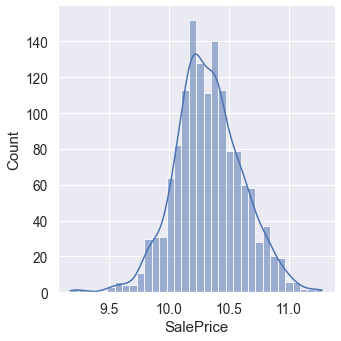

In [105]:
f = plt.figure(facecolor='whitesmoke', figsize=(15, 5))
sns.displot(data=df_train_target,kde=True)

In [106]:
print('La variable objetivo tiene la siguiente skew', df_train['SalePrice'].skew())
print('La variable objetivo tiene la siguiente kurt', df_train['SalePrice'].kurt())

La variable objetivo tiene la siguiente skew 1.487826912032595
La variable objetivo tiene la siguiente kurt 3.583326918683367


##### XGBoost-Optuna

In [107]:
train_x, test_x, train_y, test_y = train_test_split(df_train.drop('SalePrice',axis=1),df_train_target,test_size=0.15,random_state=42)

###### Definiendo funcion objetivo

In [108]:
def objective(trial,data=df_train,target=df_train_target):
    """
    Esta es la funcion objetivo utilizada en el estudio de optuna para XGBoost
    in:
    trial:numero de ejecuciones
    data <dataframe>: variables independientes
    taget <serie>: variable dependiente
    out:
    rmse : calculo del error cuadratico medio, sobre el conjunto de prueba
    """
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        #'tree_method':'gpu_hist',  this parameter means using the GPU when training our model to speedup the training process
        #'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 100),
        #'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 100),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        #'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),
        #'n_estimators': 4000,
        'n_estimators': 2000,
        #'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    #model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=30,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [109]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=100)

[I 2022-02-18 11:04:24,258] A new study created in memory with name: no-name-abcf8bea-de63-471c-8ca0-c7ad8cda24e7
c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-02-18 11:04:25,611] Trial 0 finished with value: 0.11242149415428918 and parameters: {'lambda': 0.029312293727358, 'alpha': 0.0966485380394479, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.009404361419155127, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 279}. Best is trial 0 with value: 0.11242149415428918.
c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with t

In [110]:
print('Best trial:', study.best_trial.params)

Best trial: {'lambda': 0.7056356460399491, 'alpha': 0.003604011471580289, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.008670151761326239, 'max_depth': 4, 'random_state': 48, 'min_child_weight': 2}


In [ ]:
#study.trials_dataframe()

##### Visualizacion en Optuna

In [111]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
#optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
#optuna.visualization.plot_slice(study)

In [ ]:
# optuna.visualization.plot_contour(study, params=['alpha',
#                             'max_depth',
#                             'lambda',
#                             'subsample',
#                             'learning_rate',
#                             'subsample'])

In [112]:
optuna.visualization.plot_param_importances(study)

#### Tratamiento sobre df_test

In [142]:
count_null(df_test)

Empty DataFrame
Columns: []
Index: [Count, Porcentaje, Type]

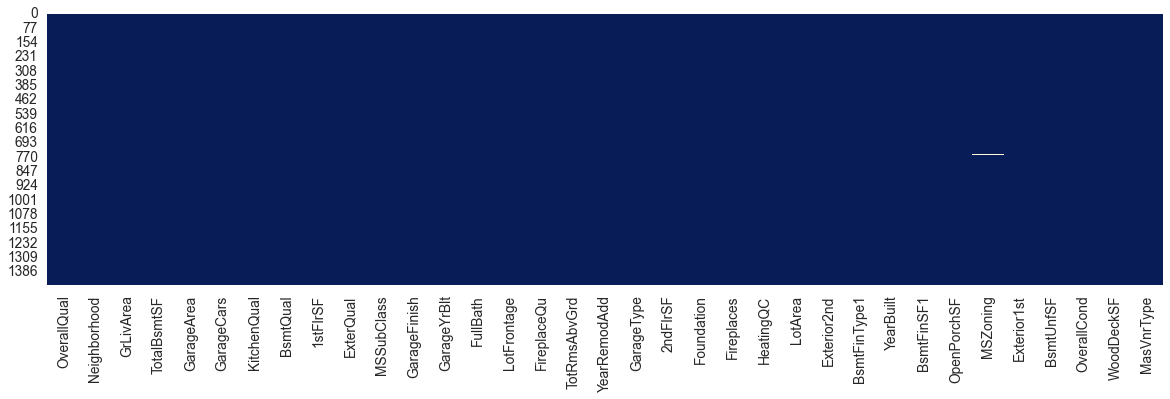

In [138]:
fig,ax = plt.subplots(figsize=(20,5))
sns.heatmap(df_test.isnull(), cbar=False, cmap='YlGnBu_r')
plt.show()

In [128]:
#Para los valores nulos de garage y basement supongo que la casa no tiene ese espacio
for c in ['GarageYrBlt','GarageArea','GarageCars']:
    df_test[c] = df_test[c].fillna(0)
for c in ['GarageType','GarageFinish']:
    df_test[c] = df_test[c].fillna('None')

for c in ['TotalBsmtSF','BsmtFinSF1','BsmtUnfSF']:
    df_test[c] = df_test[c].fillna(0)
for c in ['BsmtQual','BsmtFinType1']:
    df_test[c] = df_test[c].fillna('None')

In [132]:
df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna('None')
df_test['MasVnrType'] = df_test['MasVnrType'].fillna('None')


In [141]:
df_test['LotFrontage'] = df_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_test['MSZoning'] = df_test['MSZoning'].fillna(df_test['MSZoning'].mode()[0])
df_test['KitchenQual'] = df_test['KitchenQual'].fillna(df_test['KitchenQual'].mode()[0])
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna(df_test['Exterior2nd'].mode()[0])
df_test['Exterior1st'] = df_test['Exterior1st'].fillna(df_test['Exterior1st'].mode()[0])


##### Generando modelo

In [113]:
Best_trial= {'lambda': 0.7056356460399491, 'alpha': 0.003604011471580289, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.008670151761326239, 'max_depth': 4, 'random_state': 48, 'min_child_weight': 2}

In [115]:
# lbl = OrdinalEncoder() 
# discrete_features = ['OverallQual','GarageCars','ExterQual','BsmtQual','KitchenQual','YearBuilt','FullBath','GarageFinish','YearRemodAdd','TotRmsAbvGrd','HeatingQC','Fireplaces','OverallCond',"Foundation",'Neighborhood','MSZoning',"FireplaceQu",'MasVnrType']
# for c in discrete_features:
#     lbl.fit(df_train[[c]])
#     df_train[[c]] = lbl.transform(list(df_train[[c]].values))
#     lbl.fit(df_test[[c]])
#     df_test[[c]] = lbl.transform(list(df_test[[c]].values))

In [116]:
#df_train['SalePrice'] = boxcox1p(df_train['SalePrice'], boxcox_normmax(df_train['SalePrice'] + 1))
#df_test['SalePrice'] = boxcox1p(df_test['SalePrice'], boxcox_normmax(df_test['SalePrice'] + 1))

In [117]:
# for c in ["GarageFinish",'MSZoning','MasVnrType',"BsmtQual","FireplaceQu",'KitchenQual']:
#     df_train[c] = df_train[c].fillna('None')
#     df_test[c] = df_test[c].fillna('None')

In [280]:
# for c in ['GrLivArea', 'TotalBsmtSF','BsmtFinSF1','GarageCars']:
#     df_test[c] = df_test[c].fillna(0)

In [281]:
# for feat in ['GrLivArea', 'TotalBsmtSF','BsmtFinSF1']:
#     df_train[feat] = boxcox1p(df_train[feat], boxcox_normmax(df_train[feat] + 1))
#     df_test[feat] = boxcox1p(df_test[feat], boxcox_normmax(df_test[feat] + 1))

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [107]:

# test_list = list(df_test.columns[df_test.isnull().sum() > 0])
# # initializing get_list 
# get_list = ['OverallQual','GarageCars','ExterQual','BsmtQual','KitchenQual','YearBuilt','FullBath','GarageFinish','YearRemodAdd','TotRmsAbvGrd','HeatingQC','Fireplaces','OverallCond',"Foundation",'Neighborhood','MSZoning',"FireplaceQu",'MasVnrType']
# # getting all elements indices
# ele_indices = dict()  
# for idx, val in enumerate(test_list):
#     ele_indices.setdefault(val, []).append(idx)

# # filtering only required elements
# res = [ele_indices.get(idx, [None]) for idx in get_list]   

# # printing result 
# print("Filtered Indices of elements in list 1  : " + str(res))

Filtered Indices of elements in list 1  : [[None], [20], [None], [None], [16], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [0], [None], [6]]


In [285]:
#df_test['KitchenQual'].replace(to_replace=5.0,value='Ex',inplace=True)

In [143]:
lbl = OrdinalEncoder() 
discrete_features = df_test.columns[df_test.dtypes == 'object']
for c in discrete_features:
    lbl.fit(df_test[[c]])
    df_test[[c]] = lbl.transform(list(df_test[[c]].values))

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names



In [148]:
preds = np.zeros(df_test.shape[0])
lista_varaibles_mi.append('SalePrice')
lista_varaibles_mi_independientes = lista_varaibles_mi.remove('SalePrice')
kf = KFold(n_splits=5,random_state=24,shuffle=True)
rmse=[]
n=0
for trn_idx, test_idx in kf.split(df_train[lista_varaibles_mi_independientes],df_train['SalePrice']):
    X_tr,X_val=df_train[lista_varaibles_mi_independientes].iloc[trn_idx],df_train[lista_varaibles_mi_independientes].iloc[test_idx]
    y_tr,y_val=df_train['SalePrice'].iloc[trn_idx],df_train['SalePrice'].iloc[test_idx]
    model = xgb.XGBRegressor(**Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds+=model.predict(df_test[lista_varaibles_mi_independientes])/kf.n_splits
    rmse.append(mean_squared_error(y_val,model.predict(X_val),squared=False))
    print(n+1,rmse[n])
    n+=1

KeyError: None

In [102]:
np.mean(rmse)

99879.58546567024

#### Analisis variables categoricas

##### Univariate

##### Bivariate

In [ ]:
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    plt.xticks(rotation=90)

def get_boxplots(data,var,categorical):
    fill_missing_cat_columns(data,categorical)
    #Esta funcion convierte a var en un indice y agrupa todas las columnas de categorical en una columna variable y otra valor
    f=pd.melt(data,id_vars=var,value_vars=categorical)
    #Defino el numero de columnas como la cantidad de variables
    g=sns.FacetGrid(f,col='variable',col_wrap=5,sharex=False,sharey=False,height=5)
    #Hago un map con la funcion boxplot, utilizando como x la columna values del df f, y como el input var
    g=g.map(boxplot,'value',var)


In [ ]:
get_boxplots(data,'SalePrice',categorical)

<ul>
    <li>HeatingQC </li>
    <li>Street</li>
    <li>LotShape</li>
    <li>LandSlope</li>
    <li>CentralAir</li>
<lu>
Tiene una relacion lineal con SalesPrice


In [ ]:
categorical.describe()

In [ ]:
"""
data = df_train.copy()
lotshape_encoder = OneHotEncoder()
lotshape_reshaped = np.array(df_train['LotShape']).reshape(-1,1)
lotshape_values = lotshape_encoder.fit_transform(lotshape_reshaped)
col = np.char.lstrip(lotshape_encoder.get_feature_names_out().astype('str'), 'x0_')
df_lotshape = pd.DataFrame(lotshape_values.toarray(),columns=col)
df_encoding = pd.concat([df_train['SalePrice'],df_lotshape],axis='columns')
df_encoding['lotshape'] = (df_encoding.iloc[:, 2:] == 1).idxmax(1)
df_encoding = df_encoding.melt(id_vars='lotshape',value_vars=['SalePrice'])
"""
#sns.boxplot(x='lotshape', y='value', data=df_encoding, palette="Set3")

# le = LabelEncoder()
# lotshape_encoded=le.fit_transform(df_train['LotShape'])
#test_var_cat(lotshape_encoded,df_train['SalePrice'])

#### Analisis distribucion variables numericas

#### Univariate

In [ ]:
# def hist_norm(val):
#     ax = sns.histplot(x=val,kde=False,stats='density',color='b')#,
#     # calculate the pdf
#     x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
#     x_pdf = np.linspace(x0, x1, 100)
#     y_pdf = norm.pdf(x_pdf)
#     ax.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')


def numerical_dist(df,num_features):
    f = pd.melt(df,value_vars=num_features)
    g = sns.FacetGrid(f,col='variable', col_wrap= 5, sharex= False, sharey= False)
    g = g.map(sns.histplot, 'value',kde=True)
    

In [ ]:
def numerical_dist(df,num_features):
    f = pd.melt(df,value_vars=num_features)
    g = sns.FacetGrid(f,col='variable', col_wrap= 5, sharex= False, sharey= False)
    g = g.map(sns.histplot, 'value',kde=True)

data = df_train.copy()
num_features=data.select_dtypes('number')
numerical_dist(data,num_features)

LotFrontage, LotArea, BsmtUnSF, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageaRea tienen sesgo hacia la derecha

GarageYrBlt tienen sesgo hacia la izquierda

Hay variables sesgadas al 0

#### Bivariate

In [ ]:
def scatter_plots(df,var,num_features):
    f = pd.melt(df,id_vars=var,value_vars=num_features)
    g = sns.FacetGrid(f,col='variable', col_wrap= 5, sharex= False, sharey= False)
    g = g.map(sns.scatterplot,'value',var)

In [ ]:
scatter_plots(df_train,'SalePrice',num_features)

In [ ]:
num_features.describe()


buscar mas sobre linealidad y las transformaciones para lograrla, multicolinearidad, Durbin-watson test, tabla de frecuencia para las variables categoricas


It was also confirmed that some independent variables were correlated with each other. As expected, I visualized it as a scatter plot.
The high correlation between independent variables causes multicollinearity. The explanatory power of the model loses its reliability.
I decided to use regulation rather than choosing variables or using dimension reduction right away.
The linear model may solve the above problem through regulation (normal1, normal2).

It was difficult to visualize all variables, so I looked at the independent variables that required conversion through skewness and kurtosis. 
